### Problem Definition  


In the first question of this assignment, we implemented a Neural Networks for Image Captioning. In this model, we give an image to the network and generates sentences that describe the image.  In this model, we implement a CNN for identifying high-level features in images and an LSTM for building sentences. We use the Flickr8k dataset to train our Image Captioning network. It includes 8091 RGB images and 40455 sentences, 5 sentences for each image which is gathered from different persons.

In [ ]:
#Importing required libraries 
import numpy as np 
import pandas as pd 
import os, sys 
from PIL import Image

import random 
import matplotlib.pyplot as plt
import string

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

from tqdm import tqdm 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

### Download the dataset files from Kaggle to your google drive 

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d adityajn105/flickr8k
!cp /content/flickr8k.zip /content/drive/My\ Drive/flickr8k.zip

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6659  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3931  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1342  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2072  
promptcloud/careerbuilder-job-listing-2020

### Load the dataset to colab directory 

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/flickr8k.zip /content/flickr8k.zip

In [ ]:
!unzip /content/flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

### Vocabulary 

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.idx_2_str = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.str_2_idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.idx_2_str)

    @staticmethod
    def preprocess(text):
        # tokenize
        text = text.split()
        # convert to lower case
        text = [word.lower() for word in text]
        # remove punctuation from each token
        text = [w.translate(str.maketrans('', '', string.punctuation)) for w in text]

        return text

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.preprocess(sentence):

                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.str_2_idx[word] = idx
                    self.idx_2_str[idx] = word
                    idx += 1

    def IndexEncoding(self, text):
        tokenized_text = self.preprocess(text)
        index_encoded_text = [self.str_2_idx[token] if token in self.str_2_idx else self.str_2_idx["<UNK>"]
                                for token in tokenized_text ]
        
        return index_encoded_text

    def get_idx_2_str(self):
        return self.idx_2_str

In [ ]:
df = pd.read_csv("/content/captions.txt")

captions = df["caption"].tolist()

vocab = Vocabulary(freq_threshold = 5)
vocab.build_vocabulary(captions)


### Flickr8k Dataset

In [ ]:
class Flickr8k_Datset(torch.utils.data.Dataset):
    """
    Characterize Flickr8k Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    def __init__(self, data_root, indices,labels_root, data_transform, vocab, 
                 original_data_root = None):
        
        self.data_root = data_root
        self.data_transform = data_transform

        self.df = pd.read_csv(labels_root)
        self.df = self.df.iloc[indices]
        
        # Get img names, caption columns
        self.img_IDs = self.df["image"].tolist()
        self.captions = self.df["caption"].tolist()

        self.vocab = vocab 

            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.img_IDs)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        ID = self.img_IDs[index]

        img = Image.open(self.data_root + "/" + ID)
        image = self.data_transform(img) 

        caption = self.captions[index]
    
        index_encoded_caption = [ self.vocab.str_2_idx["<SOS>"] ]
        index_encoded_caption += self.vocab.IndexEncoding(caption)
        index_encoded_caption.append(self.vocab.str_2_idx["<EOS>"])

        caption = torch.tensor(index_encoded_caption) 

        return image, caption

    def get_vocab(self):
        return self.vocab

    def test_network(self, image, caption, rows = 3, columns = 1):
        """ 
        Plot test images, ground truth label, and the network prediction
        
        Arguments
        ------------
        inputs : torch tensor, of shape (3,n_h,n_w)
        outputs: torch tensor, of shape (1,n_h,n_w)
        labels : torch tensor, of shape (1,n_h,n_w)
        """  
        # create figure
        fig = plt.figure(figsize=(12, 8))
        
        image = torch.squeeze(image)

        plt.imshow(image.permute(1,2,0))

        # caption = captions[j * columns + i]
        plt.title(' '.join(caption),fontsize =8)
        plt.show()
        return  

### Split Dataset and Activate CUDA

In [ ]:
#train/val/test split 
random.seed(2045)

df = pd.read_csv("/content/captions.txt")

images_names = df["image"].tolist()
images_names = list(set(images_names))

num_samples = len(images_names)
random.shuffle(images_names)
train_names = images_names[0 : int(0.9 * num_samples)]
validation_names = images_names[int(0.9 * num_samples) : ]

train_indices = list(df[df.image.isin(train_names)].index.values)
validation_indices = list(df[df.image.isin(validation_names)].index.values)
test_indices = random.choices(validation_indices, k = 3 )

partition = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices}


In [ ]:
test_indices = random.choices(validation_indices, k = 3 )

partition = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices}

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
partition['test']

[31244, 415, 16183]

In [ ]:
df.iloc[partition['test']]

image                                            caption
31244  3556485995_9cd40269e9.jpg            Two men play lacrosse or field hockey .
415    1095590286_c654f7e5a9.jpg  A blond dog and a black and white dog run in a...
16183  2881441125_b580e3dd4b.jpg  Two children outside near a container of water...

## Training Main Model

#### Image Captioning Model

In [ ]:
class _CNN_model(nn.Module):

    def __init__(self, embedding_size, feature_extraction_cnn = True):
        super(_CNN_model, self).__init__()
        
        self.cnn = torchvision.models.resnet18(pretrained= True)
        if feature_extraction_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        num_feats = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_feats, embedding_size)

        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        X = self.cnn(X)
        # X = self.relu(X)
        # X = self.dropout(X)

        return X

class _RNN_model(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers):
        super(_RNN_model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        # self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class ImageCaptioning_Model(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True):
        super(ImageCaptioning_Model, self).__init__()

        self.cnn = _CNN_model(embedding_size, feature_extraction_cnn)
        self.rnn = _RNN_model(embedding_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.cnn(images)
        outputs = self.rnn(features, captions)

        return outputs 
    
    def caption_prediction(self, image, vocabulary, max_length = 30):
        predicted_caption = []

        with torch.no_grad():
            features = self.cnn(image).unsqueeze(0)
            x = features
            states = None

            for _ in range(max_length):
                hiddens, states = self.rnn.lstm(x, states)
                output = self.rnn.linear(hiddens.squeeze(0))
                predicted_idx = output.argmax(1)
                predicted_caption.append(predicted_idx.item())
                x = self.rnn.embedding(predicted_idx).unsqueeze(0)

                if vocab.idx_2_str[predicted_idx.item()] == "<EOS>":
                    break
    
        return [vocab.idx_2_str[idx] for idx in predicted_caption]    

#### padding

In [ ]:
class BatchPadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first=False, padding_value=self.pad_idx)

        return images, captions

#### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_root = "/content/Images"

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          } 

# Training and validation Data Generators
training_set = Flickr8k_Datset(data_root, partition['train'], **kwargs)

pad_idx = training_set.vocab.str_2_idx["<PAD>"]

# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  Flickr8k_Datset(data_root, partition['validation'],**kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-2
num_epochs = 100

# Model
model = ImageCaptioning_Model(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = vocab.str_2_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

train_losses = []
validation_losses = []

dataiter = iter(training_generator)
batch_train_images, batch_train_captions = dataiter.next()

dataiter = iter(validation_generator)
batch_images, batch_captions = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_images, batch_train_captions = batch_train_images.to(device), batch_train_captions.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model(batch_train_images,batch_train_captions[:-1])

    loss = criterion(batch_train_outputs.reshape(-1, batch_train_outputs.shape[2]), batch_train_captions.reshape(-1))

    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()


    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):

        # Transfer to GPU
        batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model(batch_images,batch_captions[:-1])
        
        val_loss = criterion(batch_outputs.reshape(-1, batch_outputs.shape[2]), batch_captions.reshape(-1))

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


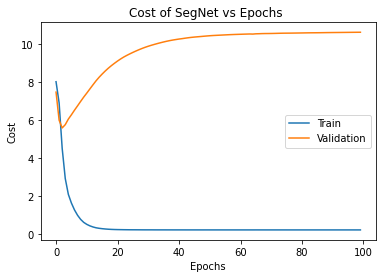

In [ ]:
plot_cost = 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()


### Part 1: ConvNet as fixed feature extractor

In [ ]:
torch.manual_seed(2045)

data_transform = transforms.Compose([transforms.Resize((112,112)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_root = "/content/Images"

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          } 

# Training and validation Data Generators
training_set = Flickr8k_Datset(data_root, partition['train'], **kwargs)

pad_idx = training_set.vocab.str_2_idx["<PAD>"]

# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  Flickr8k_Datset(data_root, partition['validation'],**kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-3
num_epochs = 5

# Model
model = ImageCaptioning_Model(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = vocab.str_2_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

train_losses = []
validation_losses = []

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_images, batch_train_captions in tqdm(training_generator):

        # Transfer to GPU
        batch_train_images, batch_train_captions = batch_train_images.to(device), batch_train_captions.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model(batch_train_images,batch_train_captions[:-1])

        loss = criterion(batch_train_outputs.reshape(-1, batch_train_outputs.shape[2]), batch_train_captions.reshape(-1))

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0
        
        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_images, batch_captions in tqdm(validation_generator):

            # Transfer to GPU
            batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = model(batch_images,batch_captions[:-1])
            
            val_loss = criterion(batch_outputs.reshape(-1, batch_outputs.shape[2]), batch_captions.reshape(-1))

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            if val_cnt % 10 == 9:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
                running_loss = 0.0

            val_cnt += 1

    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

 70%|██████▉   | 100/143 [02:16<00:49,  1.16s/it]

Cost of Train data after 100 iterations in epoch 1 : 4.364381



100%|██████████| 143/143 [03:15<00:00,  1.37s/it]

 62%|██████▎   | 10/16 [00:14<00:07,  1.22s/it]

Cost of Validation data after 10 iterations in epoch 1 : 3.337201



 70%|██████▉   | 100/143 [02:15<00:56,  1.31s/it]

Cost of Train data after 100 iterations in epoch 2 : 3.182104



100%|██████████| 143/143 [03:11<00:00,  1.34s/it]

 62%|██████▎   | 10/16 [00:13<00:07,  1.17s/it]

Cost of Validation data after 10 iterations in epoch 2 : 3.009724



 70%|██████▉   | 100/143 [02:15<00:52,  1.23s/it]

Cost of Train data after 100 iterations in epoch 3 : 2.914958



100%|██████████| 143/143 [03:11<00:00,  1.34s/it]

 62%|██████▎   | 10/16 [00:13<00:07,  1.20s/it]

Cost of Validation data after 10 iterations in epoch 3 : 2.858477



 70%|██████▉   | 100/143 [02:16<00:49,  1.16s/it]

Cost of Train data after 100 iterations in epoch 4 : 2.757225



100%|██████████| 143/143 [03:13<00:00,  1.35s/it]

 62%|██████▎   | 10/16 [00:13<00:07,  1.21s/it]

Cost of Validation data after 10 iterations in epoch 4 : 2.764178



 70%|██████▉   | 100/143 [02:20<00:50,  1.17s/it]

Cost of Train data after 100 iterations in epoch 5 : 2.651835



100%|██████████| 143/143 [03:17<00:00,  1.38s/it]

 62%|██████▎   | 10/16 [00:13<00:07,  1.19s/it]

Cost of Validation data after 10 iterations in epoch 5 : 2.694162



100%|██████████| 5/5 [17:59<00:00, 215.83s/it]


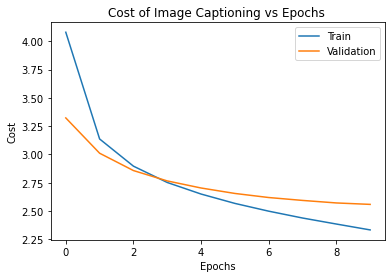

In [ ]:
weplot_cost = 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of Image Captioning vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()


Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Imagecaptioning.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
print(train_losses)

[4.080310886556452, 3.136506262359086, 2.895985303225217, 2.751636605162721, 2.6493532040736056, 2.5665695017034356, 2.497864559813813, 2.4373770160274906, 2.3840951519412594, 2.3320946860146687]


In [ ]:
print(validation_losses)

[3.322521761059761, 3.010418474674225, 2.8570490926504135, 2.765411213040352, 2.7028205692768097, 2.6546202301979065, 2.6185920983552933, 2.5929563492536545, 2.5706202536821365, 2.5578654408454895]


#### Test the Network 

  0%|          | 0/3 [00:00<?, ?it/s]

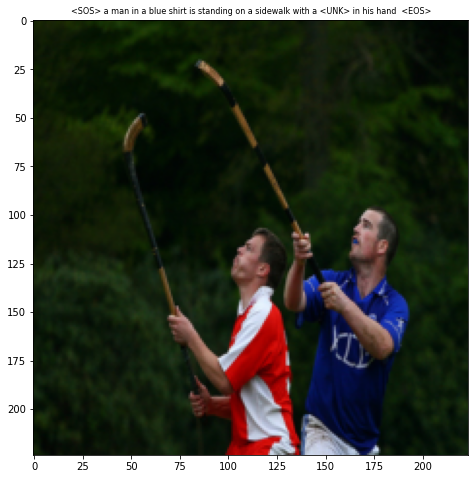

 33%|███▎      | 1/3 [00:00<00:00,  2.44it/s]

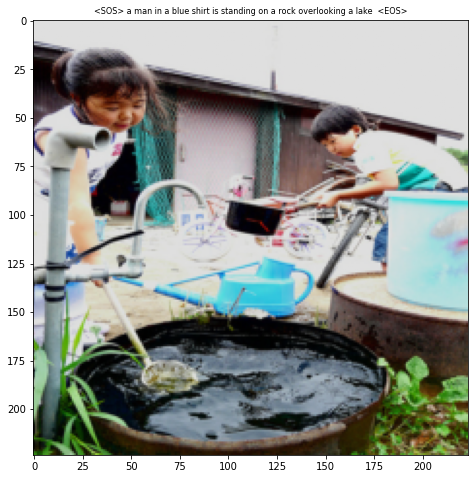

 67%|██████▋   | 2/3 [00:00<00:00,  2.63it/s]

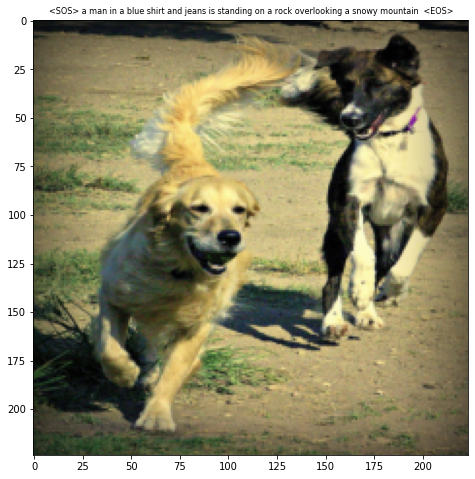

100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


In [ ]:
# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-4

data_root = "/content/Images"

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          }
          
test_set =  Flickr8k_Datset(data_root, partition['test'],**kwargs)

pad_idx = test_set.vocab.str_2_idx["<PAD>"] 

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

PATH = '/content/drive/My Drive/Imagecaptioning.pth'
 
model2 =  ImageCaptioning_Model(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)
model2.load_state_dict(torch.load(PATH))

with torch.set_grad_enabled(False):
    for batch_images, batch_captions in tqdm(test_generator):

        # Transfer to GPU
        batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model2.caption_prediction(batch_images,batch_captions[:-1])
        test_set.test_network(batch_images.cpu(),batch_outputs)

### Part 2: fine-tuned ConvNet 

In [ ]:
torch.manual_seed(2045)

data_transform = transforms.Compose([transforms.Resize((112,112)),
                                     transforms.ToTensor()])
                                    #  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_root = "/content/Images"

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          } 

# Training and validation Data Generators
training_set = Flickr8k_Datset(data_root, partition['train'], **kwargs)

pad_idx = training_set.vocab.str_2_idx["<PAD>"]

# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  Flickr8k_Datset(data_root, partition['validation'],**kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-3
num_epochs = 10

# Model
model2 = ImageCaptioning_Model(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = False).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = vocab.str_2_idx["<PAD>"])
optimizer = optim.Adam(model2.parameters(), lr = learning_rate)

train_losses2 = []
validation_losses2 = []


# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_images, batch_train_captions in tqdm(training_generator):

        # Transfer to GPU
        batch_train_images, batch_train_captions = batch_train_images.to(device), batch_train_captions.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model2(batch_train_images,batch_train_captions[:-1])

        loss = criterion(batch_train_outputs.reshape(-1, batch_train_outputs.shape[2]), batch_train_captions.reshape(-1))

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0
        
        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_images, batch_captions in tqdm(validation_generator):

            # Transfer to GPU
            batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = model2(batch_images,batch_captions[:-1])
            
            val_loss = criterion(batch_outputs.reshape(-1, batch_outputs.shape[2]), batch_captions.reshape(-1))

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1

    train_losses2.append(running_trainloss / train_cnt)
    validation_losses2.append(running_valloss / val_cnt)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  1%|          | 1/143 [00:03<07:49,  3.31s/it]

  1%|▏         | 2/143 [00:03<05:48,  2.47s/it]

  2%|▏         | 3/143 [00:06<05:40,  2.43s/it]

  3%|▎         | 4/143 [00:06<04:18,  1.86s/it]

  3%|▎         | 5/143 [00:09<04:42,  2.05s/it]

  4%|▍         | 6/143 [00:09<03:38,  1.59s/it]

  5%|▍         | 7/143 [00:11<04:04,  1.79s/it]

  6%|▌         | 8/143 [00:12<03:10,  1.41s/it]

  6%|▋         | 9/143 [00:14<03:47,  1.70s/it]

  7%|▋         | 10/143 [00:15<02:58,  1.34s/it]

  8%|▊         | 11/143 [00:17<03:36,  1.64s/it]

  8%|▊         | 12/143 [00:18<02:51,  1.31s/it]

  9%|▉         | 13/143 [00:20<03:33,  1.64s/it]

 10%|▉         | 14/143 [00:21<02:48,  1.30s/it]

 10%|█         | 15/143 [00:23<03:27,  1.62s/it]

 11%|█         | 16/143 [00:24<02:42,  1.28s/it]

 12%|█▏        | 17/143 [00:26<03:21,  1.60s/it]

 13%|█▎        | 18/143 [00:26<02:40,  1.29s/it]

 13%|█▎        | 19/143 [00

Cost of Train data after 100 iterations in epoch 1 : 4.362889




 71%|███████   | 101/143 [02:28<01:07,  1.60s/it]

 71%|███████▏  | 102/143 [02:29<00:52,  1.27s/it]

 72%|███████▏  | 103/143 [02:31<01:03,  1.59s/it]

 73%|███████▎  | 104/143 [02:31<00:49,  1.27s/it]

 73%|███████▎  | 105/143 [02:34<01:00,  1.60s/it]

 74%|███████▍  | 106/143 [02:34<00:47,  1.28s/it]

 75%|███████▍  | 107/143 [02:36<00:56,  1.56s/it]

 76%|███████▌  | 108/143 [02:37<00:43,  1.24s/it]

 76%|███████▌  | 109/143 [02:39<00:54,  1.60s/it]

 77%|███████▋  | 110/143 [02:40<00:41,  1.27s/it]

 78%|███████▊  | 111/143 [02:42<00:50,  1.59s/it]

 78%|███████▊  | 112/143 [02:43<00:39,  1.27s/it]

 79%|███████▉  | 113/143 [02:45<00:47,  1.60s/it]

 80%|███████▉  | 114/143 [02:46<00:36,  1.27s/it]

 80%|████████  | 115/143 [02:48<00:45,  1.64s/it]

 81%|████████  | 116/143 [02:49<00:35,  1.30s/it]

 82%|████████▏ | 117/143 [02:51<00:41,  1.60s/it]

 83%|████████▎ | 118/143 [02:51<00:31,  1.27s/it]

 83%|████████▎ | 119/143 [02:54<00:38,  1.61s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 2 : 3.181110




 71%|███████   | 101/143 [02:30<01:09,  1.65s/it]

 71%|███████▏  | 102/143 [02:30<00:53,  1.31s/it]

 72%|███████▏  | 103/143 [02:33<01:03,  1.58s/it]

 73%|███████▎  | 104/143 [02:33<00:51,  1.32s/it]

 73%|███████▎  | 105/143 [02:35<00:59,  1.56s/it]

 74%|███████▍  | 106/143 [02:36<00:49,  1.34s/it]

 75%|███████▍  | 107/143 [02:38<00:55,  1.55s/it]

 76%|███████▌  | 108/143 [02:39<00:47,  1.36s/it]

 76%|███████▌  | 109/143 [02:41<00:52,  1.55s/it]

 77%|███████▋  | 110/143 [02:42<00:45,  1.39s/it]

 78%|███████▊  | 111/143 [02:44<00:48,  1.52s/it]

 78%|███████▊  | 112/143 [02:45<00:44,  1.42s/it]

 79%|███████▉  | 113/143 [02:47<00:45,  1.51s/it]

 80%|███████▉  | 114/143 [02:48<00:42,  1.46s/it]

 80%|████████  | 115/143 [02:50<00:41,  1.50s/it]

 81%|████████  | 116/143 [02:51<00:38,  1.44s/it]

 82%|████████▏ | 117/143 [02:53<00:38,  1.47s/it]

 83%|████████▎ | 118/143 [02:54<00:36,  1.48s/it]

 83%|████████▎ | 119/143 [02:56<00:34,  1.45s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 3 : 2.922129




 71%|███████   | 101/143 [02:28<00:59,  1.41s/it]

 71%|███████▏  | 102/143 [02:30<01:02,  1.52s/it]

 72%|███████▏  | 103/143 [02:31<00:56,  1.42s/it]

 73%|███████▎  | 104/143 [02:33<00:58,  1.50s/it]

 73%|███████▎  | 105/143 [02:34<00:53,  1.40s/it]

 74%|███████▍  | 106/143 [02:36<00:56,  1.52s/it]

 75%|███████▍  | 107/143 [02:37<00:49,  1.38s/it]

 76%|███████▌  | 108/143 [02:39<00:52,  1.50s/it]

 76%|███████▌  | 109/143 [02:40<00:47,  1.41s/it]

 77%|███████▋  | 110/143 [02:41<00:48,  1.46s/it]

 78%|███████▊  | 111/143 [02:43<00:45,  1.43s/it]

 78%|███████▊  | 112/143 [02:44<00:44,  1.45s/it]

 79%|███████▉  | 113/143 [02:46<00:43,  1.46s/it]

 80%|███████▉  | 114/143 [02:47<00:41,  1.45s/it]

 80%|████████  | 115/143 [02:49<00:41,  1.49s/it]

 81%|████████  | 116/143 [02:50<00:38,  1.41s/it]

 82%|████████▏ | 117/143 [02:52<00:38,  1.48s/it]

 83%|████████▎ | 118/143 [02:53<00:35,  1.40s/it]

 83%|████████▎ | 119/143 [02:54<00:35,  1.48s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 4 : 2.772513




 71%|███████   | 101/143 [02:28<01:04,  1.55s/it]

 71%|███████▏  | 102/143 [02:29<00:56,  1.37s/it]

 72%|███████▏  | 103/143 [02:31<01:01,  1.54s/it]

 73%|███████▎  | 104/143 [02:32<00:51,  1.32s/it]

 73%|███████▎  | 105/143 [02:34<00:59,  1.56s/it]

 74%|███████▍  | 106/143 [02:35<00:48,  1.31s/it]

 75%|███████▍  | 107/143 [02:37<00:57,  1.60s/it]

 76%|███████▌  | 108/143 [02:38<00:45,  1.30s/it]

 76%|███████▌  | 109/143 [02:40<00:56,  1.65s/it]

 77%|███████▋  | 110/143 [02:41<00:43,  1.31s/it]

 78%|███████▊  | 111/143 [02:43<00:53,  1.67s/it]

 78%|███████▊  | 112/143 [02:44<00:40,  1.32s/it]

 79%|███████▉  | 113/143 [02:46<00:48,  1.63s/it]

 80%|███████▉  | 114/143 [02:46<00:37,  1.30s/it]

 80%|████████  | 115/143 [02:49<00:45,  1.61s/it]

 81%|████████  | 116/143 [02:49<00:35,  1.32s/it]

 82%|████████▏ | 117/143 [02:52<00:40,  1.57s/it]

 83%|████████▎ | 118/143 [02:52<00:32,  1.30s/it]

 83%|████████▎ | 119/143 [02:54<00:37,  1.57s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 5 : 2.669604




 71%|███████   | 101/143 [02:30<01:07,  1.61s/it]

 71%|███████▏  | 102/143 [02:30<00:52,  1.28s/it]

 72%|███████▏  | 103/143 [02:33<01:06,  1.65s/it]

 73%|███████▎  | 104/143 [02:33<00:51,  1.31s/it]

 73%|███████▎  | 105/143 [02:36<01:02,  1.64s/it]

 74%|███████▍  | 106/143 [02:36<00:47,  1.30s/it]

 75%|███████▍  | 107/143 [02:39<00:57,  1.61s/it]

 76%|███████▌  | 108/143 [02:39<00:44,  1.27s/it]

 76%|███████▌  | 109/143 [02:42<00:55,  1.63s/it]

 77%|███████▋  | 110/143 [02:42<00:42,  1.29s/it]

 78%|███████▊  | 111/143 [02:45<00:52,  1.65s/it]

 78%|███████▊  | 112/143 [02:45<00:40,  1.31s/it]

 79%|███████▉  | 113/143 [02:48<00:48,  1.63s/it]

 80%|███████▉  | 114/143 [02:48<00:37,  1.29s/it]

 80%|████████  | 115/143 [02:50<00:46,  1.64s/it]

 81%|████████  | 116/143 [02:51<00:35,  1.31s/it]

 82%|████████▏ | 117/143 [02:53<00:42,  1.63s/it]

 83%|████████▎ | 118/143 [02:54<00:32,  1.29s/it]

 83%|████████▎ | 119/143 [02:56<00:37,  1.57s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 6 : 2.597153




 71%|███████   | 101/143 [02:29<01:09,  1.65s/it]

 71%|███████▏  | 102/143 [02:29<00:53,  1.30s/it]

 72%|███████▏  | 103/143 [02:32<01:06,  1.66s/it]

 73%|███████▎  | 104/143 [02:32<00:51,  1.31s/it]

 73%|███████▎  | 105/143 [02:35<01:02,  1.65s/it]

 74%|███████▍  | 106/143 [02:35<00:48,  1.31s/it]

 75%|███████▍  | 107/143 [02:38<00:58,  1.63s/it]

 76%|███████▌  | 108/143 [02:38<00:45,  1.29s/it]

 76%|███████▌  | 109/143 [02:40<00:54,  1.61s/it]

 77%|███████▋  | 110/143 [02:41<00:42,  1.29s/it]

 78%|███████▊  | 111/143 [02:43<00:53,  1.66s/it]

 78%|███████▊  | 112/143 [02:44<00:40,  1.32s/it]

 79%|███████▉  | 113/143 [02:46<00:49,  1.64s/it]

 80%|███████▉  | 114/143 [02:47<00:37,  1.30s/it]

 80%|████████  | 115/143 [02:49<00:46,  1.67s/it]

 81%|████████  | 116/143 [02:50<00:35,  1.31s/it]

 82%|████████▏ | 117/143 [02:52<00:42,  1.62s/it]

 83%|████████▎ | 118/143 [02:53<00:32,  1.29s/it]

 83%|████████▎ | 119/143 [02:55<00:39,  1.63s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 7 : 2.531775




 71%|███████   | 101/143 [02:30<01:07,  1.60s/it]

 71%|███████▏  | 102/143 [02:31<00:52,  1.27s/it]

 72%|███████▏  | 103/143 [02:33<01:03,  1.59s/it]

 73%|███████▎  | 104/143 [02:34<00:49,  1.27s/it]

 73%|███████▎  | 105/143 [02:36<01:00,  1.60s/it]

 74%|███████▍  | 106/143 [02:36<00:46,  1.27s/it]

 75%|███████▍  | 107/143 [02:39<00:58,  1.62s/it]

 76%|███████▌  | 108/143 [02:39<00:45,  1.29s/it]

 76%|███████▌  | 109/143 [02:42<00:56,  1.67s/it]

 77%|███████▋  | 110/143 [02:42<00:43,  1.32s/it]

 78%|███████▊  | 111/143 [02:45<00:53,  1.66s/it]

 78%|███████▊  | 112/143 [02:45<00:40,  1.31s/it]

 79%|███████▉  | 113/143 [02:48<00:48,  1.63s/it]

 80%|███████▉  | 114/143 [02:48<00:37,  1.30s/it]

 80%|████████  | 115/143 [02:51<00:46,  1.65s/it]

 81%|████████  | 116/143 [02:51<00:35,  1.31s/it]

 82%|████████▏ | 117/143 [02:54<00:42,  1.63s/it]

 83%|████████▎ | 118/143 [02:54<00:32,  1.30s/it]

 83%|████████▎ | 119/143 [02:57<00:39,  1.64s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 8 : 2.475228




 71%|███████   | 101/143 [02:29<01:00,  1.44s/it]

 71%|███████▏  | 102/143 [02:31<01:01,  1.49s/it]

 72%|███████▏  | 103/143 [02:32<00:57,  1.43s/it]

 73%|███████▎  | 104/143 [02:34<00:56,  1.46s/it]

 73%|███████▎  | 105/143 [02:35<00:55,  1.45s/it]

 74%|███████▍  | 106/143 [02:37<00:53,  1.43s/it]

 75%|███████▍  | 107/143 [02:38<00:51,  1.44s/it]

 76%|███████▌  | 108/143 [02:40<00:50,  1.46s/it]

 76%|███████▌  | 109/143 [02:41<00:48,  1.44s/it]

 77%|███████▋  | 110/143 [02:43<00:48,  1.46s/it]

 78%|███████▊  | 111/143 [02:44<00:47,  1.47s/it]

 78%|███████▊  | 112/143 [02:45<00:44,  1.44s/it]

 79%|███████▉  | 113/143 [02:47<00:44,  1.47s/it]

 80%|███████▉  | 114/143 [02:48<00:41,  1.44s/it]

 80%|████████  | 115/143 [02:50<00:40,  1.46s/it]

 81%|████████  | 116/143 [02:51<00:38,  1.41s/it]

 82%|████████▏ | 117/143 [02:53<00:37,  1.45s/it]

 83%|████████▎ | 118/143 [02:54<00:35,  1.44s/it]

 83%|████████▎ | 119/143 [02:55<00:34,  1.44s/it]

 84%|████████▍ | 120/143 [02:

Cost of Train data after 100 iterations in epoch 9 : 2.428795




 71%|███████   | 101/143 [02:28<01:06,  1.58s/it]

 71%|███████▏  | 102/143 [02:28<00:51,  1.25s/it]

 72%|███████▏  | 103/143 [02:31<01:04,  1.61s/it]

 73%|███████▎  | 104/143 [02:31<00:49,  1.28s/it]

 73%|███████▎  | 105/143 [02:33<01:00,  1.58s/it]

 74%|███████▍  | 106/143 [02:34<00:46,  1.26s/it]

 75%|███████▍  | 107/143 [02:36<00:57,  1.61s/it]

 76%|███████▌  | 108/143 [02:37<00:44,  1.28s/it]

 76%|███████▌  | 109/143 [02:39<00:54,  1.61s/it]

 77%|███████▋  | 110/143 [02:40<00:42,  1.29s/it]

 78%|███████▊  | 111/143 [02:42<00:52,  1.63s/it]

 78%|███████▊  | 112/143 [02:43<00:40,  1.29s/it]

 79%|███████▉  | 113/143 [02:45<00:48,  1.63s/it]

 80%|███████▉  | 114/143 [02:46<00:37,  1.30s/it]

 80%|████████  | 115/143 [02:48<00:45,  1.64s/it]

 81%|████████  | 116/143 [02:49<00:35,  1.30s/it]

 82%|████████▏ | 117/143 [02:51<00:40,  1.56s/it]

 83%|████████▎ | 118/143 [02:51<00:31,  1.24s/it]

 83%|████████▎ | 119/143 [02:54<00:38,  1.60s/it]

 84%|████████▍ | 120/143 [02:

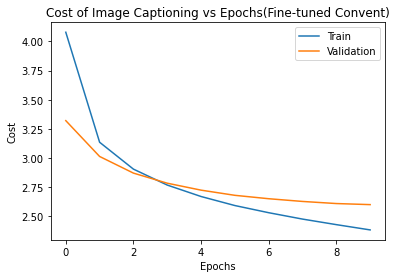

In [ ]:
plot_cost = 1
# plot the cost
if plot_cost:
    plt.plot(train_losses2)
    plt.plot(validation_losses2)
    plt.title("Cost of Image Captioning vs Epochs(Fine-tuned Convnet)")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Imagecaptioning_fine.pth'
torch.save(model2.state_dict(), PATH)

In [ ]:
print(train_losses2)

[4.078675328434764, 3.1360490522184574, 2.9057671290177565, 2.7691511274217726, 2.6711048713097205, 2.5936791663403276, 2.5323114211742697, 2.4776362589189223, 2.430080648902413, 2.38485342305857]


In [ ]:
print(validation_losses2)

[3.321148321032524, 3.014218255877495, 2.8716562539339066, 2.785195291042328, 2.7255802899599075, 2.681242972612381, 2.6521302312612534, 2.628824532032013, 2.610808700323105, 2.601569637656212]


#### Test the Network 

  0%|          | 0/3 [00:00<?, ?it/s]

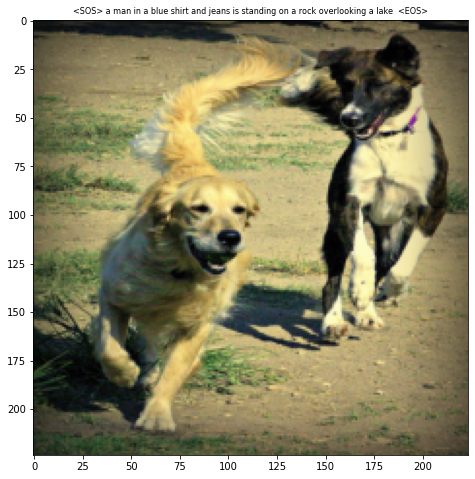

 33%|███▎      | 1/3 [00:00<00:00,  2.37it/s]

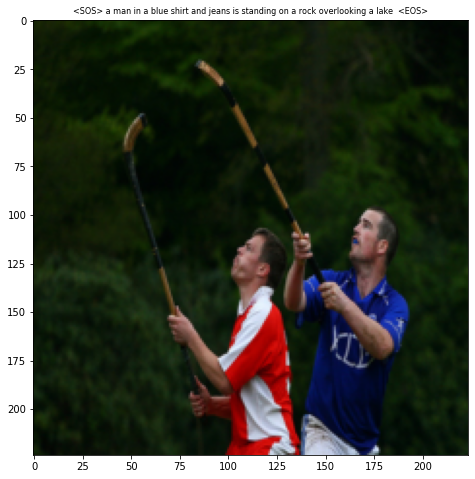

 67%|██████▋   | 2/3 [00:00<00:00,  2.49it/s]

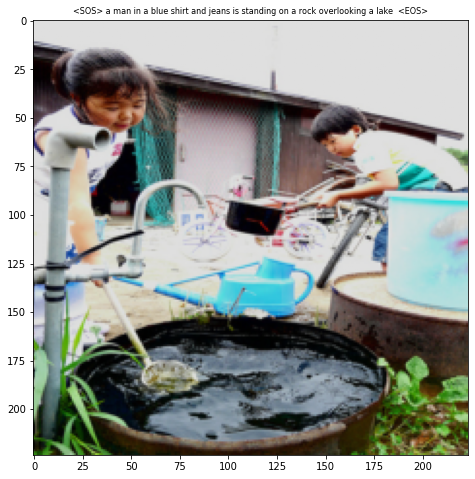

100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


In [ ]:
# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-4

data_root = "/content/Images"

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          }
          
test_set =  Flickr8k_Datset(data_root, partition['test'],**kwargs)

pad_idx = test_set.vocab.str_2_idx["<PAD>"] 

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

PATH = '/content/drive/My Drive/Imagecaptioning_fine.pth'
 
model4 =  ImageCaptioning_Model(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)
model4.load_state_dict(torch.load(PATH))

with torch.set_grad_enabled(False):
    for batch_images, batch_captions in tqdm(test_generator):

        # Transfer to GPU
        batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)

        # Model computations
        # forward + backward + optimize
        batch_outputs = model4.caption_prediction(batch_images,batch_captions[:-1])
        test_set.test_network(batch_images.cpu(),batch_outputs)

## (Bonus)
Bi-directional LSTM 

#### Image Captioning Model2

In [ ]:
class _CNN_model2(nn.Module):

    def __init__(self, embedding_size, feature_extraction_cnn = True):
        super(_CNN_model2, self).__init__()
        
        self.cnn = torchvision.models.resnet18(pretrained= True)
        if feature_extraction_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        num_feats = self.cnn.fc.in_features
        self.cnn.fc = nn.Linear(num_feats, embedding_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        X = self.cnn(X)
        X = self.relu(X)
        X = self.dropout(X)

        return X

class _RNN_model2(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers):
        super(_RNN_model2, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, int(hidden_size/2), num_layers,bidirectional = True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embedding(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class ImageCaptioning_Model2(nn.Module):
    
    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True):
        super(ImageCaptioning_Model2, self).__init__()

        self.cnn = _CNN_model2(embedding_size, feature_extraction_cnn)
        self.rnn = _RNN_model2(embedding_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.cnn(images)
        outputs = self.rnn(features, captions)
        return outputs 
    
    def caption_prediction(self, image, vocabulary, max_length = 30):
        predicted_caption = []

        with torch.no_grad():
            features = self.cnn(image).unsqueeze(0)
            x = features
            states = None

            for _ in range(max_length):
                hiddens, states = self.rnn.lstm(x, states)
                output = self.rnn.linear(hiddens.squeeze(0))
                predicted_idx = output.argmax(1)
                predicted_caption.append(predicted_idx.item())
                x = self.rnn.embedding(predicted_idx).unsqueeze(0)

                if vocab.idx_2_str[predicted_idx.item()] == "<EOS>":
                    break
    
        return [vocab.idx_2_str[idx] for idx in predicted_caption]    

#### padding

In [ ]:
class BatchPadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first=False, padding_value=self.pad_idx)

        return images, captions

#### Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_root = "/content/Images"

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          } 

# Training and validation Data Generators
training_set = Flickr8k_Datset(data_root, partition['train'], **kwargs)

pad_idx = training_set.vocab.str_2_idx["<PAD>"]

# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  Flickr8k_Datset(data_root, partition['validation'],**kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 400

# Model
model = ImageCaptioning_Model2(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = vocab.str_2_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

train_losses = []
validation_losses = []

dataiter = iter(training_generator)
batch_train_images, batch_train_captions = dataiter.next()

dataiter = iter(validation_generator)
batch_images, batch_captions = dataiter.next()

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training

    # Transfer to GPU
    batch_train_images, batch_train_captions = batch_train_images.to(device), batch_train_captions.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model(batch_train_images,batch_train_captions[:-1])

    loss = criterion(batch_train_outputs.reshape(-1, batch_train_outputs.shape[2]), batch_train_captions.reshape(-1))

    loss.backward()
    optimizer.step()

    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()


    if train_cnt % 10 == 9:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1

    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):

        # Transfer to GPU
        batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model(batch_images,batch_captions[:-1])
        
        val_loss = criterion(batch_outputs.reshape(-1, batch_outputs.shape[2]), batch_captions.reshape(-1))

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)







  0%|          | 0/400 [00:00<?, ?it/s]





  0%|          | 2/400 [00:00<00:23, 16.76it/s]





  1%|          | 4/400 [00:00<00:23, 17.00it/s]





  2%|▏         | 7/400 [00:00<00:21, 18.35it/s]





  2%|▎         | 10/400 [00:00<00:19, 20.27it/s]





  3%|▎         | 13/400 [00:00<00:17, 21.91it/s]





  4%|▍         | 16/400 [00:00<00:16, 23.20it/s]





  5%|▍         | 19/400 [00:00<00:15, 24.25it/s]





  6%|▌         | 22/400 [00:00<00:15, 24.80it/s]





  6%|▋         | 25/400 [00:01<00:15, 25.00it/s]





  7%|▋         | 28/400 [00:01<00:14, 25.49it/s]





  8%|▊         | 31/400 [00:01<00:14, 25.74it/s]





  8%|▊         | 34/400 [00:01<00:14, 25.96it/s]





  9%|▉         | 37/400 [00:01<00:13, 26.12it/s]





 10%|█         | 40/400 [00:01<00:13, 26.33it/s]





 11%|█         | 43/400 [00:01<00:13, 26.38it/s]





 12%|█▏        | 46/400 [00:01<00:13, 26.36it/s]





 12%|█▏        | 49/400 [00:01<00:13, 26.33it/s]





 13%|█▎        | 52/400 [00:02<00:

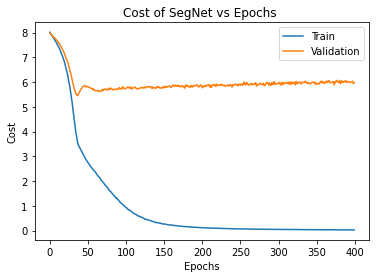

In [ ]:
plot_cost = 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of SegNet vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()


### Part 1: ConvNet as fixed feature extractor

In [ ]:
torch.manual_seed(2045)

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_root = "/content/Images"

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          } 

# Training and validation Data Generators
training_set = Flickr8k_Datset(data_root, partition['train'], **kwargs)

pad_idx = training_set.vocab.str_2_idx["<PAD>"]

# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  Flickr8k_Datset(data_root, partition['validation'],**kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-4
num_epochs = 10

# Model
model = ImageCaptioning_Model2(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = vocab.str_2_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

train_losses = []
validation_losses = []


# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_images, batch_train_captions in tqdm(training_generator):

        # Transfer to GPU
        batch_train_images, batch_train_captions = batch_train_images.to(device), batch_train_captions.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model(batch_train_images,batch_train_captions[:-1])

        loss = criterion(batch_train_outputs.reshape(-1, batch_train_outputs.shape[2]), batch_train_captions.reshape(-1))

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0
        
        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_images, batch_captions in tqdm(validation_generator):

            # Transfer to GPU
            batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = model(batch_images,batch_captions[:-1])
            
            val_loss = criterion(batch_outputs.reshape(-1, batch_outputs.shape[2]), batch_captions.reshape(-1))

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1

    train_losses.append(running_trainloss / train_cnt)
    validation_losses.append(running_valloss / val_cnt)

  4%|▍         | 101/2276 [00:10<03:46,  9.60it/s]

Cost of Train data after 100 iterations in epoch 1 : 7.599543



  9%|▉         | 201/2276 [00:20<03:27,  9.98it/s]

Cost of Train data after 200 iterations in epoch 1 : 5.551661



 13%|█▎        | 300/2276 [00:30<03:16, 10.04it/s]

Cost of Train data after 300 iterations in epoch 1 : 4.298447



 18%|█▊        | 402/2276 [00:40<03:01, 10.33it/s]

Cost of Train data after 400 iterations in epoch 1 : 4.076716



 22%|██▏       | 500/2276 [00:50<03:01,  9.80it/s]

Cost of Train data after 500 iterations in epoch 1 : 3.925725



 26%|██▋       | 600/2276 [01:01<02:48,  9.94it/s]

Cost of Train data after 600 iterations in epoch 1 : 3.772113



 31%|███       | 701/2276 [01:11<02:31, 10.39it/s]

Cost of Train data after 700 iterations in epoch 1 : 3.666186



 35%|███▌      | 801/2276 [01:21<02:29,  9.83it/s]

Cost of Train data after 800 iterations in epoch 1 : 3.515712



 40%|███▉      | 901/2276 [01:31<02:16, 10.06it/s]

Cost of Train data after 900 iterations in epoch 1 : 3.421994



 44%|████▍     | 1001/2276 [01:41<02:07,  9.96it/s]

Cost of Train data after 1000 iterations in epoch 1 : 3.344547



 48%|████▊     | 1101/2276 [01:51<01:52, 10.47it/s]

Cost of Train data after 1100 iterations in epoch 1 : 3.202426



 53%|█████▎    | 1201/2276 [02:01<01:47, 10.02it/s]

Cost of Train data after 1200 iterations in epoch 1 : 3.088920



 57%|█████▋    | 1300/2276 [02:12<01:43,  9.41it/s]

Cost of Train data after 1300 iterations in epoch 1 : 3.048452



 62%|██████▏   | 1400/2276 [02:22<01:31,  9.54it/s]

Cost of Train data after 1400 iterations in epoch 1 : 2.983619



 66%|██████▌   | 1502/2276 [02:32<01:16, 10.05it/s]

Cost of Train data after 1500 iterations in epoch 1 : 2.902087



 70%|███████   | 1600/2276 [02:42<01:10,  9.54it/s]

Cost of Train data after 1600 iterations in epoch 1 : 2.840984



 75%|███████▍  | 1700/2276 [02:53<00:58,  9.91it/s]

Cost of Train data after 1700 iterations in epoch 1 : 2.784499



 79%|███████▉  | 1800/2276 [03:03<00:47,  9.94it/s]

Cost of Train data after 1800 iterations in epoch 1 : 2.712484



 84%|████████▎ | 1901/2276 [03:13<00:41,  9.12it/s]

Cost of Train data after 1900 iterations in epoch 1 : 2.641778



 88%|████████▊ | 2002/2276 [03:23<00:27, 10.12it/s]

Cost of Train data after 2000 iterations in epoch 1 : 2.613995



 92%|█████████▏| 2102/2276 [03:34<00:17, 10.14it/s]

Cost of Train data after 2100 iterations in epoch 1 : 2.559199



 97%|█████████▋| 2202/2276 [03:44<00:07, 10.18it/s]

Cost of Train data after 2200 iterations in epoch 1 : 2.504693



100%|██████████| 2276/2276 [03:52<00:00,  9.81it/s]

 39%|███▉      | 100/254 [00:10<00:15, 10.18it/s]

Cost of Validation data after 100 iterations in epoch 1 : 2.493009



 80%|███████▉  | 202/254 [00:20<00:05, 10.09it/s]

Cost of Validation data after 200 iterations in epoch 1 : 2.429972



  4%|▍         | 100/2276 [00:10<03:47,  9.58it/s]

Cost of Train data after 100 iterations in epoch 2 : 2.398318



  9%|▉         | 200/2276 [00:21<03:40,  9.39it/s]

Cost of Train data after 200 iterations in epoch 2 : 2.413907



 13%|█▎        | 302/2276 [00:31<03:17,  9.97it/s]

Cost of Train data after 300 iterations in epoch 2 : 2.325480



 18%|█▊        | 402/2276 [00:42<03:08,  9.93it/s]

Cost of Train data after 400 iterations in epoch 2 : 2.301958



 22%|██▏       | 500/2276 [00:52<03:06,  9.51it/s]

Cost of Train data after 500 iterations in epoch 2 : 2.264593



 26%|██▋       | 601/2276 [01:02<02:40, 10.41it/s]

Cost of Train data after 600 iterations in epoch 2 : 2.241345



 31%|███       | 700/2276 [01:12<02:50,  9.24it/s]

Cost of Train data after 700 iterations in epoch 2 : 2.218508



 35%|███▌      | 800/2276 [01:23<02:33,  9.59it/s]

Cost of Train data after 800 iterations in epoch 2 : 2.171535



 40%|███▉      | 902/2276 [01:33<02:20,  9.77it/s]

Cost of Train data after 900 iterations in epoch 2 : 2.122246



 44%|████▍     | 1000/2276 [01:43<02:16,  9.34it/s]

Cost of Train data after 1000 iterations in epoch 2 : 2.099021



 48%|████▊     | 1100/2276 [01:54<02:05,  9.40it/s]

Cost of Train data after 1100 iterations in epoch 2 : 2.083561



 53%|█████▎    | 1202/2276 [02:04<01:45, 10.15it/s]

Cost of Train data after 1200 iterations in epoch 2 : 2.036456



 57%|█████▋    | 1301/2276 [02:15<01:30, 10.75it/s]

Cost of Train data after 1300 iterations in epoch 2 : 2.006195



 62%|██████▏   | 1401/2276 [02:25<01:25, 10.18it/s]

Cost of Train data after 1400 iterations in epoch 2 : 1.981504



 66%|██████▌   | 1500/2276 [02:36<01:25,  9.10it/s]

Cost of Train data after 1500 iterations in epoch 2 : 1.976386



 70%|███████   | 1602/2276 [02:46<01:07, 10.06it/s]

Cost of Train data after 1600 iterations in epoch 2 : 1.951281



 75%|███████▍  | 1701/2276 [02:57<01:14,  7.75it/s]

Cost of Train data after 1700 iterations in epoch 2 : 1.933758



 79%|███████▉  | 1800/2276 [03:07<00:47,  9.94it/s]

Cost of Train data after 1800 iterations in epoch 2 : 1.867051



 83%|████████▎ | 1900/2276 [03:18<00:40,  9.29it/s]

Cost of Train data after 1900 iterations in epoch 2 : 1.885883



 88%|████████▊ | 2001/2276 [03:28<00:27,  9.83it/s]

Cost of Train data after 2000 iterations in epoch 2 : 1.837269



 92%|█████████▏| 2101/2276 [03:39<00:18,  9.51it/s]

Cost of Train data after 2100 iterations in epoch 2 : 1.801182



 97%|█████████▋| 2201/2276 [03:49<00:08,  8.80it/s]

Cost of Train data after 2200 iterations in epoch 2 : 1.787592



100%|██████████| 2276/2276 [03:57<00:00,  9.58it/s]

 39%|███▉      | 100/254 [00:10<00:17,  9.05it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.809417



 79%|███████▊  | 200/254 [00:21<00:05,  9.49it/s]

Cost of Validation data after 200 iterations in epoch 2 : 1.783346



  4%|▍         | 101/2276 [00:10<03:59,  9.09it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.766013



  9%|▉         | 201/2276 [00:21<03:38,  9.49it/s]

Cost of Train data after 200 iterations in epoch 3 : 1.704686



 13%|█▎        | 301/2276 [00:32<03:37,  9.08it/s]

Cost of Train data after 300 iterations in epoch 3 : 1.694643



 18%|█▊        | 401/2276 [00:42<03:18,  9.45it/s]

Cost of Train data after 400 iterations in epoch 3 : 1.675136



 22%|██▏       | 500/2276 [00:53<03:30,  8.42it/s]

Cost of Train data after 500 iterations in epoch 3 : 1.656296



 26%|██▋       | 600/2276 [01:03<02:54,  9.60it/s]

Cost of Train data after 600 iterations in epoch 3 : 1.622765



 31%|███       | 700/2276 [01:14<02:51,  9.18it/s]

Cost of Train data after 700 iterations in epoch 3 : 1.663039



 35%|███▌      | 801/2276 [01:25<02:37,  9.38it/s]

Cost of Train data after 800 iterations in epoch 3 : 1.618115



 40%|███▉      | 901/2276 [01:36<02:27,  9.31it/s]

Cost of Train data after 900 iterations in epoch 3 : 1.579959



 44%|████▍     | 1001/2276 [01:46<02:17,  9.27it/s]

Cost of Train data after 1000 iterations in epoch 3 : 1.610527



 48%|████▊     | 1101/2276 [01:57<02:08,  9.18it/s]

Cost of Train data after 1100 iterations in epoch 3 : 1.557946



 53%|█████▎    | 1201/2276 [02:07<01:50,  9.77it/s]

Cost of Train data after 1200 iterations in epoch 3 : 1.555817



 57%|█████▋    | 1301/2276 [02:18<01:45,  9.22it/s]

Cost of Train data after 1300 iterations in epoch 3 : 1.565543



 62%|██████▏   | 1401/2276 [02:29<01:35,  9.15it/s]

Cost of Train data after 1400 iterations in epoch 3 : 1.489009



 66%|██████▌   | 1501/2276 [02:39<01:20,  9.68it/s]

Cost of Train data after 1500 iterations in epoch 3 : 1.456892



 70%|███████   | 1601/2276 [02:50<01:08,  9.92it/s]

Cost of Train data after 1600 iterations in epoch 3 : 1.471147



 75%|███████▍  | 1701/2276 [03:01<00:58,  9.85it/s]

Cost of Train data after 1700 iterations in epoch 3 : 1.491861



 79%|███████▉  | 1802/2276 [03:11<00:50,  9.35it/s]

Cost of Train data after 1800 iterations in epoch 3 : 1.431551



 83%|████████▎ | 1900/2276 [03:22<00:42,  8.82it/s]

Cost of Train data after 1900 iterations in epoch 3 : 1.462629



 88%|████████▊ | 2000/2276 [03:33<00:27, 10.04it/s]

Cost of Train data after 2000 iterations in epoch 3 : 1.387290



 92%|█████████▏| 2101/2276 [03:43<00:17,  9.86it/s]

Cost of Train data after 2100 iterations in epoch 3 : 1.422042



 97%|█████████▋| 2201/2276 [03:54<00:08,  8.85it/s]

Cost of Train data after 2200 iterations in epoch 3 : 1.387610



100%|██████████| 2276/2276 [04:02<00:00,  9.38it/s]

 40%|███▉      | 101/254 [00:10<00:16,  9.52it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.404705



 79%|███████▊  | 200/254 [00:21<00:05,  9.70it/s]

Cost of Validation data after 200 iterations in epoch 3 : 1.408019



  4%|▍         | 100/2276 [00:11<04:04,  8.90it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.362209



  9%|▉         | 201/2276 [00:21<03:49,  9.05it/s]

Cost of Train data after 200 iterations in epoch 4 : 1.326971



 13%|█▎        | 300/2276 [00:32<03:41,  8.93it/s]

Cost of Train data after 300 iterations in epoch 4 : 1.348760



 18%|█▊        | 401/2276 [00:43<03:10,  9.82it/s]

Cost of Train data after 400 iterations in epoch 4 : 1.330810



 22%|██▏       | 501/2276 [00:54<03:30,  8.43it/s]

Cost of Train data after 500 iterations in epoch 4 : 1.287654



 26%|██▋       | 601/2276 [01:05<03:02,  9.18it/s]

Cost of Train data after 600 iterations in epoch 4 : 1.287764



 31%|███       | 700/2276 [01:15<02:55,  9.01it/s]

Cost of Train data after 700 iterations in epoch 4 : 1.308550



 35%|███▌      | 801/2276 [01:26<02:45,  8.93it/s]

Cost of Train data after 800 iterations in epoch 4 : 1.320905



 40%|███▉      | 902/2276 [01:37<02:26,  9.38it/s]

Cost of Train data after 900 iterations in epoch 4 : 1.257946



 44%|████▍     | 1001/2276 [01:48<02:22,  8.96it/s]

Cost of Train data after 1000 iterations in epoch 4 : 1.243100



 48%|████▊     | 1101/2276 [01:59<02:16,  8.60it/s]

Cost of Train data after 1100 iterations in epoch 4 : 1.266910



 53%|█████▎    | 1201/2276 [02:10<01:59,  8.98it/s]

Cost of Train data after 1200 iterations in epoch 4 : 1.192690



 57%|█████▋    | 1301/2276 [02:21<01:50,  8.80it/s]

Cost of Train data after 1300 iterations in epoch 4 : 1.217947



 62%|██████▏   | 1401/2276 [02:32<01:37,  9.00it/s]

Cost of Train data after 1400 iterations in epoch 4 : 1.224391



 66%|██████▌   | 1501/2276 [02:43<01:28,  8.74it/s]

Cost of Train data after 1500 iterations in epoch 4 : 1.220827



 70%|███████   | 1601/2276 [02:54<01:09,  9.69it/s]

Cost of Train data after 1600 iterations in epoch 4 : 1.172014



 75%|███████▍  | 1701/2276 [03:05<01:04,  8.97it/s]

Cost of Train data after 1700 iterations in epoch 4 : 1.181654



 79%|███████▉  | 1800/2276 [03:15<00:54,  8.76it/s]

Cost of Train data after 1800 iterations in epoch 4 : 1.154901



 83%|████████▎ | 1900/2276 [03:26<00:40,  9.18it/s]

Cost of Train data after 1900 iterations in epoch 4 : 1.170182



 88%|████████▊ | 2000/2276 [03:37<00:30,  9.13it/s]

Cost of Train data after 2000 iterations in epoch 4 : 1.160235



 92%|█████████▏| 2100/2276 [03:48<00:18,  9.29it/s]

Cost of Train data after 2100 iterations in epoch 4 : 1.139542



 97%|█████████▋| 2200/2276 [03:59<00:07,  9.52it/s]

Cost of Train data after 2200 iterations in epoch 4 : 1.135853



100%|██████████| 2276/2276 [04:07<00:00,  9.20it/s]

 39%|███▉      | 100/254 [00:11<00:16,  9.50it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.161461



 79%|███████▊  | 200/254 [00:22<00:05,  9.09it/s]

Cost of Validation data after 200 iterations in epoch 4 : 1.142793



  4%|▍         | 101/2276 [00:11<04:12,  8.62it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.121018



  9%|▉         | 201/2276 [00:22<04:16,  8.09it/s]

Cost of Train data after 200 iterations in epoch 5 : 1.098413



 13%|█▎        | 300/2276 [00:33<03:46,  8.71it/s]

Cost of Train data after 300 iterations in epoch 5 : 1.076505



 18%|█▊        | 401/2276 [00:44<03:31,  8.88it/s]

Cost of Train data after 400 iterations in epoch 5 : 1.091616



 22%|██▏       | 500/2276 [00:55<03:20,  8.88it/s]

Cost of Train data after 500 iterations in epoch 5 : 1.067941



 26%|██▋       | 600/2276 [01:06<02:58,  9.41it/s]

Cost of Train data after 600 iterations in epoch 5 : 1.040498



 31%|███       | 701/2276 [01:17<02:51,  9.18it/s]

Cost of Train data after 700 iterations in epoch 5 : 1.063422



 35%|███▌      | 800/2276 [01:28<02:48,  8.74it/s]

Cost of Train data after 800 iterations in epoch 5 : 1.040787



 40%|███▉      | 900/2276 [01:39<02:34,  8.90it/s]

Cost of Train data after 900 iterations in epoch 5 : 1.049495



 44%|████▍     | 1000/2276 [01:50<02:23,  8.89it/s]

Cost of Train data after 1000 iterations in epoch 5 : 1.029956



 48%|████▊     | 1100/2276 [02:01<02:10,  9.00it/s]

Cost of Train data after 1100 iterations in epoch 5 : 1.031119



 53%|█████▎    | 1200/2276 [02:12<01:57,  9.14it/s]

Cost of Train data after 1200 iterations in epoch 5 : 0.980304



 57%|█████▋    | 1301/2276 [02:23<01:43,  9.46it/s]

Cost of Train data after 1300 iterations in epoch 5 : 1.029072



 62%|██████▏   | 1401/2276 [02:35<01:36,  9.08it/s]

Cost of Train data after 1400 iterations in epoch 5 : 0.993751



 66%|██████▌   | 1502/2276 [02:46<01:19,  9.78it/s]

Cost of Train data after 1500 iterations in epoch 5 : 0.992127



 70%|███████   | 1600/2276 [02:57<01:19,  8.55it/s]

Cost of Train data after 1600 iterations in epoch 5 : 0.990052



 75%|███████▍  | 1700/2276 [03:08<01:05,  8.81it/s]

Cost of Train data after 1700 iterations in epoch 5 : 0.957686



 79%|███████▉  | 1800/2276 [03:19<00:53,  8.91it/s]

Cost of Train data after 1800 iterations in epoch 5 : 0.943940



 83%|████████▎ | 1900/2276 [03:30<00:40,  9.31it/s]

Cost of Train data after 1900 iterations in epoch 5 : 0.978743



 88%|████████▊ | 2000/2276 [03:41<00:32,  8.50it/s]

Cost of Train data after 2000 iterations in epoch 5 : 0.954866



 92%|█████████▏| 2101/2276 [03:52<00:19,  9.06it/s]

Cost of Train data after 2100 iterations in epoch 5 : 0.960785



 97%|█████████▋| 2201/2276 [04:03<00:08,  8.86it/s]

Cost of Train data after 2200 iterations in epoch 5 : 0.975847



100%|██████████| 2276/2276 [04:12<00:00,  9.03it/s]

 40%|███▉      | 101/254 [00:11<00:15,  9.71it/s]

Cost of Validation data after 100 iterations in epoch 5 : 0.988284



 79%|███████▉  | 201/254 [00:22<00:05,  9.32it/s]

Cost of Validation data after 200 iterations in epoch 5 : 0.971990



  4%|▍         | 101/2276 [00:11<04:03,  8.93it/s]

Cost of Train data after 100 iterations in epoch 6 : 0.924508



  9%|▉         | 200/2276 [00:22<03:45,  9.20it/s]

Cost of Train data after 200 iterations in epoch 6 : 0.902960



 13%|█▎        | 301/2276 [00:34<03:48,  8.64it/s]

Cost of Train data after 300 iterations in epoch 6 : 0.902484



 18%|█▊        | 402/2276 [00:45<03:24,  9.16it/s]

Cost of Train data after 400 iterations in epoch 6 : 0.909152



 22%|██▏       | 500/2276 [00:56<03:11,  9.26it/s]

Cost of Train data after 500 iterations in epoch 6 : 0.903474



 26%|██▋       | 601/2276 [01:07<03:08,  8.88it/s]

Cost of Train data after 600 iterations in epoch 6 : 0.861226



 31%|███       | 701/2276 [01:18<02:57,  8.88it/s]

Cost of Train data after 700 iterations in epoch 6 : 0.896526



 35%|███▌      | 800/2276 [01:29<02:52,  8.58it/s]

Cost of Train data after 800 iterations in epoch 6 : 0.873517



 40%|███▉      | 901/2276 [01:41<02:55,  7.85it/s]

Cost of Train data after 900 iterations in epoch 6 : 0.885752



 44%|████▍     | 1001/2276 [01:52<02:20,  9.10it/s]

Cost of Train data after 1000 iterations in epoch 6 : 0.890539



 48%|████▊     | 1100/2276 [02:03<02:17,  8.57it/s]


Cost of Train data after 1100 iterations in epoch 6 : 0.846339


 53%|█████▎    | 1200/2276 [02:14<02:15,  7.95it/s]

Cost of Train data after 1200 iterations in epoch 6 : 0.851505



 57%|█████▋    | 1300/2276 [02:26<01:47,  9.05it/s]


Cost of Train data after 1300 iterations in epoch 6 : 0.856416


 62%|██████▏   | 1400/2276 [02:37<01:39,  8.85it/s]

Cost of Train data after 1400 iterations in epoch 6 : 0.860980



 66%|██████▌   | 1500/2276 [02:48<01:30,  8.54it/s]

Cost of Train data after 1500 iterations in epoch 6 : 0.846030



 70%|███████   | 1601/2276 [03:00<01:23,  8.12it/s]

Cost of Train data after 1600 iterations in epoch 6 : 0.800726



 75%|███████▍  | 1701/2276 [03:11<01:06,  8.60it/s]

Cost of Train data after 1700 iterations in epoch 6 : 0.837236



 79%|███████▉  | 1801/2276 [03:22<00:54,  8.76it/s]

Cost of Train data after 1800 iterations in epoch 6 : 0.823349



 84%|████████▎ | 1901/2276 [03:33<00:41,  8.96it/s]

Cost of Train data after 1900 iterations in epoch 6 : 0.837491



 88%|████████▊ | 2001/2276 [03:45<00:31,  8.61it/s]

Cost of Train data after 2000 iterations in epoch 6 : 0.809479



 92%|█████████▏| 2100/2276 [03:56<00:19,  9.08it/s]

Cost of Train data after 2100 iterations in epoch 6 : 0.824146



 97%|█████████▋| 2200/2276 [04:07<00:08,  8.82it/s]

Cost of Train data after 2200 iterations in epoch 6 : 0.803945



100%|██████████| 2276/2276 [04:16<00:00,  8.88it/s]

 40%|███▉      | 101/254 [00:11<00:17,  8.84it/s]

Cost of Validation data after 100 iterations in epoch 6 : 0.846935



 79%|███████▉  | 201/254 [00:22<00:05,  9.73it/s]

Cost of Validation data after 200 iterations in epoch 6 : 0.837560



  4%|▍         | 101/2276 [00:11<04:34,  7.92it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.777445



  9%|▉         | 201/2276 [00:23<03:46,  9.15it/s]

Cost of Train data after 200 iterations in epoch 7 : 0.798893



 13%|█▎        | 301/2276 [00:34<03:44,  8.78it/s]

Cost of Train data after 300 iterations in epoch 7 : 0.786457



 18%|█▊        | 401/2276 [00:45<03:22,  9.25it/s]

Cost of Train data after 400 iterations in epoch 7 : 0.770093



 22%|██▏       | 499/2276 [00:56<03:17,  8.99it/s]

Cost of Train data after 500 iterations in epoch 7 : 0.766003



 26%|██▋       | 601/2276 [01:08<03:08,  8.89it/s]

Cost of Train data after 600 iterations in epoch 7 : 0.758394



 31%|███       | 701/2276 [01:19<03:07,  8.42it/s]

Cost of Train data after 700 iterations in epoch 7 : 0.741777



 35%|███▌      | 801/2276 [01:31<02:54,  8.47it/s]

Cost of Train data after 800 iterations in epoch 7 : 0.756791



 40%|███▉      | 900/2276 [01:43<02:43,  8.43it/s]

Cost of Train data after 900 iterations in epoch 7 : 0.751592



 44%|████▍     | 1001/2276 [01:54<02:29,  8.54it/s]

Cost of Train data after 1000 iterations in epoch 7 : 0.752195



 48%|████▊     | 1101/2276 [02:06<02:24,  8.14it/s]

Cost of Train data after 1100 iterations in epoch 7 : 0.719363



 53%|█████▎    | 1201/2276 [02:17<02:11,  8.16it/s]

Cost of Train data after 1200 iterations in epoch 7 : 0.731076



 57%|█████▋    | 1300/2276 [02:29<01:50,  8.87it/s]


Cost of Train data after 1300 iterations in epoch 7 : 0.737608


 62%|██████▏   | 1401/2276 [02:41<01:36,  9.08it/s]

Cost of Train data after 1400 iterations in epoch 7 : 0.760482



 66%|██████▌   | 1501/2276 [02:52<01:28,  8.79it/s]

Cost of Train data after 1500 iterations in epoch 7 : 0.713018



 70%|███████   | 1600/2276 [03:04<01:15,  8.89it/s]

Cost of Train data after 1600 iterations in epoch 7 : 0.700409



 75%|███████▍  | 1700/2276 [03:15<01:06,  8.71it/s]

Cost of Train data after 1700 iterations in epoch 7 : 0.730511



 79%|███████▉  | 1801/2276 [03:27<00:59,  7.97it/s]

Cost of Train data after 1800 iterations in epoch 7 : 0.685617



 83%|████████▎ | 1900/2276 [03:39<00:46,  8.14it/s]

Cost of Train data after 1900 iterations in epoch 7 : 0.705362



 88%|████████▊ | 2002/2276 [03:50<00:32,  8.49it/s]

Cost of Train data after 2000 iterations in epoch 7 : 0.692042



 92%|█████████▏| 2100/2276 [04:02<00:20,  8.62it/s]


Cost of Train data after 2100 iterations in epoch 7 : 0.714998


 97%|█████████▋| 2201/2276 [04:14<00:08,  8.71it/s]

Cost of Train data after 2200 iterations in epoch 7 : 0.673885



100%|██████████| 2276/2276 [04:23<00:00,  8.65it/s]

 40%|███▉      | 101/254 [00:11<00:17,  8.60it/s]

Cost of Validation data after 100 iterations in epoch 7 : 0.727643



 79%|███████▉  | 201/254 [00:23<00:06,  8.59it/s]

Cost of Validation data after 200 iterations in epoch 7 : 0.753469



  4%|▍         | 101/2276 [00:11<04:41,  7.71it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.688116



  9%|▉         | 200/2276 [00:23<04:01,  8.61it/s]

Cost of Train data after 200 iterations in epoch 8 : 0.647138



 13%|█▎        | 301/2276 [00:35<03:51,  8.54it/s]

Cost of Train data after 300 iterations in epoch 8 : 0.670750



 18%|█▊        | 401/2276 [00:47<03:42,  8.43it/s]

Cost of Train data after 400 iterations in epoch 8 : 0.668140



 22%|██▏       | 501/2276 [00:59<03:23,  8.74it/s]

Cost of Train data after 500 iterations in epoch 8 : 0.696333



 26%|██▋       | 601/2276 [01:11<03:52,  7.20it/s]

Cost of Train data after 600 iterations in epoch 8 : 0.657485



 31%|███       | 701/2276 [01:22<02:59,  8.76it/s]

Cost of Train data after 700 iterations in epoch 8 : 0.668666



 35%|███▌      | 801/2276 [01:34<03:21,  7.32it/s]

Cost of Train data after 800 iterations in epoch 8 : 0.657393



 40%|███▉      | 901/2276 [01:46<02:52,  7.99it/s]

Cost of Train data after 900 iterations in epoch 8 : 0.647592



 44%|████▍     | 1001/2276 [01:58<02:25,  8.74it/s]

Cost of Train data after 1000 iterations in epoch 8 : 0.654753



 48%|████▊     | 1101/2276 [02:10<02:20,  8.39it/s]

Cost of Train data after 1100 iterations in epoch 8 : 0.635927



 53%|█████▎    | 1200/2276 [02:22<02:21,  7.59it/s]

Cost of Train data after 1200 iterations in epoch 8 : 0.615523



 57%|█████▋    | 1300/2276 [02:34<02:03,  7.93it/s]

Cost of Train data after 1300 iterations in epoch 8 : 0.622701



 62%|██████▏   | 1401/2276 [02:47<01:41,  8.58it/s]

Cost of Train data after 1400 iterations in epoch 8 : 0.622398



 66%|██████▌   | 1501/2276 [02:58<01:33,  8.29it/s]

Cost of Train data after 1500 iterations in epoch 8 : 0.619616



 70%|███████   | 1600/2276 [03:10<01:21,  8.24it/s]

Cost of Train data after 1600 iterations in epoch 8 : 0.608042



 75%|███████▍  | 1701/2276 [03:22<01:06,  8.66it/s]

Cost of Train data after 1700 iterations in epoch 8 : 0.624570



 79%|███████▉  | 1800/2276 [03:34<00:55,  8.61it/s]


Cost of Train data after 1800 iterations in epoch 8 : 0.623401


 84%|████████▎ | 1901/2276 [03:46<00:43,  8.66it/s]

Cost of Train data after 1900 iterations in epoch 8 : 0.605642



 88%|████████▊ | 2000/2276 [03:58<00:37,  7.35it/s]

Cost of Train data after 2000 iterations in epoch 8 : 0.612327



 92%|█████████▏| 2100/2276 [04:10<00:21,  8.35it/s]

Cost of Train data after 2100 iterations in epoch 8 : 0.596742



 97%|█████████▋| 2201/2276 [04:22<00:08,  8.72it/s]

Cost of Train data after 2200 iterations in epoch 8 : 0.601985



100%|██████████| 2276/2276 [04:31<00:00,  8.40it/s]

 40%|███▉      | 101/254 [00:11<00:17,  8.82it/s]

Cost of Validation data after 100 iterations in epoch 8 : 0.652812



 79%|███████▊  | 200/254 [00:23<00:06,  7.80it/s]

Cost of Validation data after 200 iterations in epoch 8 : 0.664963



  4%|▍         | 100/2276 [00:12<04:23,  8.26it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.562210



  9%|▉         | 200/2276 [00:23<03:55,  8.83it/s]

Cost of Train data after 200 iterations in epoch 9 : 0.583431



 13%|█▎        | 300/2276 [00:35<03:54,  8.44it/s]

Cost of Train data after 300 iterations in epoch 9 : 0.570578



 18%|█▊        | 401/2276 [00:47<03:44,  8.37it/s]

Cost of Train data after 400 iterations in epoch 9 : 0.564129



 22%|██▏       | 500/2276 [00:59<03:24,  8.66it/s]

Cost of Train data after 500 iterations in epoch 9 : 0.564791



 26%|██▋       | 600/2276 [01:11<03:45,  7.43it/s]

Cost of Train data after 600 iterations in epoch 9 : 0.568738



 31%|███       | 701/2276 [01:23<03:15,  8.05it/s]

Cost of Train data after 700 iterations in epoch 9 : 0.572303



 35%|███▌      | 801/2276 [01:36<03:11,  7.70it/s]

Cost of Train data after 800 iterations in epoch 9 : 0.552334



 40%|███▉      | 901/2276 [01:47<02:33,  8.96it/s]

Cost of Train data after 900 iterations in epoch 9 : 0.552974



 44%|████▍     | 1001/2276 [01:59<02:29,  8.51it/s]

Cost of Train data after 1000 iterations in epoch 9 : 0.569134



 48%|████▊     | 1101/2276 [02:11<02:34,  7.59it/s]

Cost of Train data after 1100 iterations in epoch 9 : 0.554426



 53%|█████▎    | 1200/2276 [02:23<01:59,  9.03it/s]

Cost of Train data after 1200 iterations in epoch 9 : 0.560393



 57%|█████▋    | 1300/2276 [02:35<01:52,  8.69it/s]

Cost of Train data after 1300 iterations in epoch 9 : 0.573987



 62%|██████▏   | 1401/2276 [02:48<01:42,  8.54it/s]

Cost of Train data after 1400 iterations in epoch 9 : 0.545338



 66%|██████▌   | 1501/2276 [03:00<01:41,  7.60it/s]

Cost of Train data after 1500 iterations in epoch 9 : 0.541057



 70%|███████   | 1601/2276 [03:12<01:17,  8.68it/s]

Cost of Train data after 1600 iterations in epoch 9 : 0.539030



 75%|███████▍  | 1699/2276 [03:24<01:09,  8.26it/s]

Cost of Train data after 1700 iterations in epoch 9 : 0.564655



 79%|███████▉  | 1799/2276 [03:36<00:58,  8.20it/s]


Cost of Train data after 1800 iterations in epoch 9 : 0.550714


 83%|████████▎ | 1900/2276 [03:48<00:48,  7.81it/s]

Cost of Train data after 1900 iterations in epoch 9 : 0.546952



 88%|████████▊ | 2000/2276 [04:01<00:40,  6.84it/s]

Cost of Train data after 2000 iterations in epoch 9 : 0.553251



 92%|█████████▏| 2100/2276 [04:14<00:21,  8.29it/s]

Cost of Train data after 2100 iterations in epoch 9 : 0.541249



 97%|█████████▋| 2200/2276 [04:27<00:09,  7.94it/s]

Cost of Train data after 2200 iterations in epoch 9 : 0.534720



100%|██████████| 2276/2276 [04:36<00:00,  8.23it/s]

 40%|███▉      | 101/254 [00:12<00:17,  8.78it/s]

Cost of Validation data after 100 iterations in epoch 9 : 0.575120



 79%|███████▊  | 200/254 [00:24<00:06,  8.35it/s]

Cost of Validation data after 200 iterations in epoch 9 : 0.605692



  4%|▍         | 101/2276 [00:13<04:23,  8.24it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.513762



  9%|▉         | 201/2276 [00:25<04:08,  8.35it/s]

Cost of Train data after 200 iterations in epoch 10 : 0.513058



 13%|█▎        | 301/2276 [00:37<04:03,  8.12it/s]

Cost of Train data after 300 iterations in epoch 10 : 0.521971



 18%|█▊        | 401/2276 [00:50<04:23,  7.12it/s]

Cost of Train data after 400 iterations in epoch 10 : 0.509230



 22%|██▏       | 500/2276 [01:02<04:07,  7.16it/s]

Cost of Train data after 500 iterations in epoch 10 : 0.485526



 26%|██▋       | 600/2276 [01:15<03:49,  7.31it/s]

Cost of Train data after 600 iterations in epoch 10 : 0.507924



 31%|███       | 701/2276 [01:27<03:22,  7.79it/s]

Cost of Train data after 700 iterations in epoch 10 : 0.501846



 35%|███▌      | 801/2276 [01:40<02:43,  9.00it/s]

Cost of Train data after 800 iterations in epoch 10 : 0.509548



 40%|███▉      | 901/2276 [01:52<02:47,  8.20it/s]

Cost of Train data after 900 iterations in epoch 10 : 0.495415



 44%|████▍     | 1001/2276 [02:05<02:51,  7.44it/s]

Cost of Train data after 1000 iterations in epoch 10 : 0.484816



 48%|████▊     | 1100/2276 [02:17<02:45,  7.11it/s]

Cost of Train data after 1100 iterations in epoch 10 : 0.492884



 53%|█████▎    | 1199/2276 [02:30<02:11,  8.18it/s]

Cost of Train data after 1200 iterations in epoch 10 : 0.498347



 57%|█████▋    | 1301/2276 [02:42<02:06,  7.72it/s]

Cost of Train data after 1300 iterations in epoch 10 : 0.491323



 61%|██████▏   | 1399/2276 [02:55<01:48,  8.11it/s]


Cost of Train data after 1400 iterations in epoch 10 : 0.473508


 66%|██████▌   | 1501/2276 [03:07<01:42,  7.53it/s]

Cost of Train data after 1500 iterations in epoch 10 : 0.481150



 70%|███████   | 1600/2276 [03:20<01:20,  8.43it/s]

Cost of Train data after 1600 iterations in epoch 10 : 0.486093



 75%|███████▍  | 1701/2276 [03:32<01:13,  7.85it/s]

Cost of Train data after 1700 iterations in epoch 10 : 0.471107



 79%|███████▉  | 1801/2276 [03:45<01:08,  6.96it/s]

Cost of Train data after 1800 iterations in epoch 10 : 0.464056



 83%|████████▎ | 1899/2276 [03:57<00:45,  8.26it/s]

Cost of Train data after 1900 iterations in epoch 10 : 0.477970



 88%|████████▊ | 2001/2276 [04:10<00:37,  7.31it/s]

Cost of Train data after 2000 iterations in epoch 10 : 0.463045



 92%|█████████▏| 2099/2276 [04:22<00:24,  7.22it/s]


Cost of Train data after 2100 iterations in epoch 10 : 0.451895


 97%|█████████▋| 2200/2276 [04:35<00:10,  6.99it/s]

Cost of Train data after 2200 iterations in epoch 10 : 0.488864



100%|██████████| 2276/2276 [04:45<00:00,  7.97it/s]

 40%|███▉      | 101/254 [00:12<00:18,  8.20it/s]

Cost of Validation data after 100 iterations in epoch 10 : 0.523435



 79%|███████▉  | 201/254 [00:25<00:06,  7.81it/s]

Cost of Validation data after 200 iterations in epoch 10 : 0.529451



100%|██████████| 10/10 [47:29<00:00, 284.99s/it]


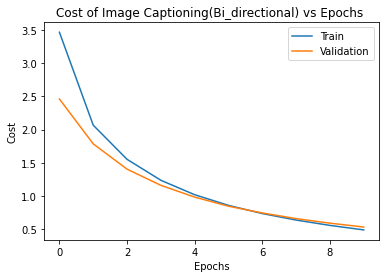

In [ ]:
plt.plot(train_losses)
plt.plot(validation_losses)
plt.title("Cost of Image Captioning(Bi_directional) vs Epochs ")
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Imagecaptioning_bi.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
print(train_losses)

[3.468332463282902, 2.067123525067247, 1.5527819134491399, 1.236802103963594, 1.0191182276800352, 0.8584975752527768, 0.7351567057634071, 0.6372414617185433, 0.5567730029485137, 0.48865318285900383]


In [ ]:
train_losses = [3.468332463282902, 2.067123525067247, 1.5527819134491399, 1.236802103963594, 1.0191182276800352, 0.8584975752527768, 0.7351567057634071, 0.6372414617185433, 0.5567730029485137, 0.48865318285900383]

In [ ]:
print(validation_losses)

[2.462051112820783, 1.7858499532609473, 1.4048411487125037, 1.1607344453259716, 0.9830720112549038, 0.8459442650943291, 0.7444188385967194, 0.6588849636513417, 0.5903943931962562, 0.5321476445423337]


In [ ]:
validation_losses = [2.462051112820783, 1.7858499532609473, 1.4048411487125037, 1.1607344453259716, 0.9830720112549038, 0.8459442650943291, 0.7444188385967194, 0.6588849636513417, 0.5903943931962562, 0.5321476445423337]

#### Test the Network 

  0%|          | 0/3 [00:00<?, ?it/s]

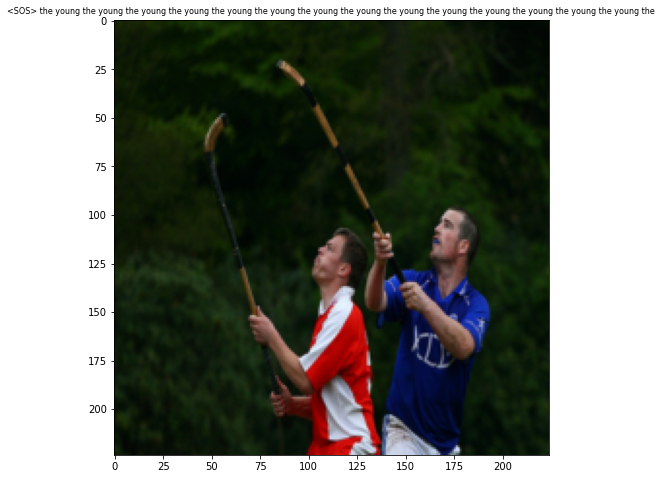

 33%|███▎      | 1/3 [00:00<00:00,  2.38it/s]

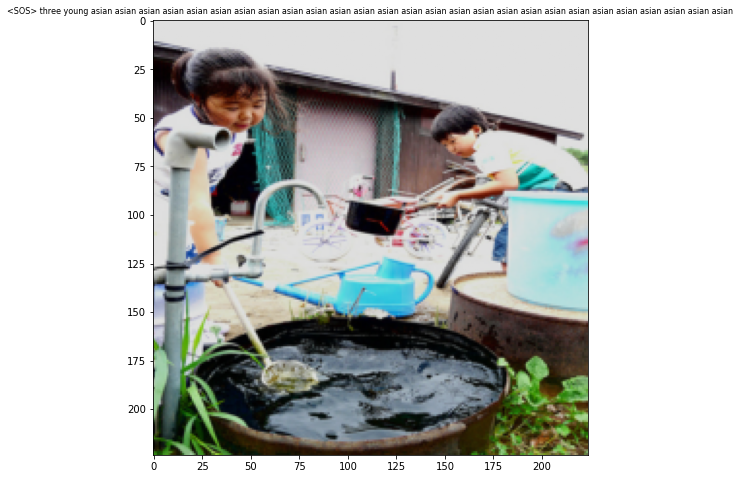

 67%|██████▋   | 2/3 [00:00<00:00,  2.53it/s]

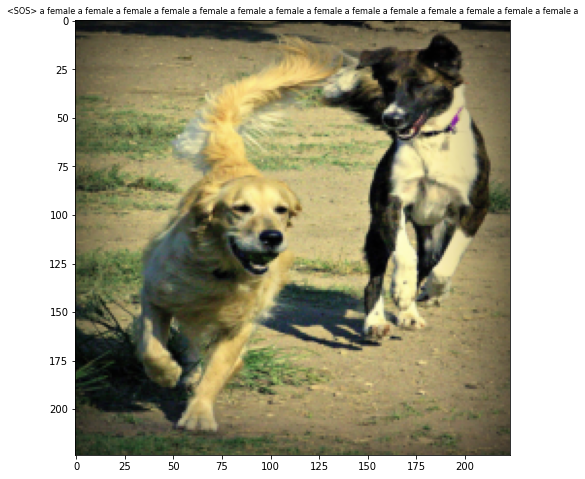

100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


In [ ]:
# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-4

data_root = "/content/Images"

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          }
          
test_set =  Flickr8k_Datset(data_root, partition['test'],**kwargs)

pad_idx = test_set.vocab.str_2_idx["<PAD>"] 

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

PATH = '/content/drive/My Drive/Imagecaptioning_bi.pth'
 
model =  ImageCaptioning_Model2(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = True).to(device)
model.load_state_dict(torch.load(PATH))

with torch.set_grad_enabled(False):
    for batch_images, batch_captions in tqdm(test_generator):

        # Transfer to GPU
        batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model.caption_prediction(batch_images,batch_captions[:-1])
        test_set.test_network(batch_images.cpu(),batch_outputs)

### Part 2: fine-tuned ConvNet 

In [ ]:
torch.manual_seed(2045)

data_transform = transforms.Compose([transforms.Resize((112,112)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_root = "/content/Images"

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          } 

# Training and validation Data Generators
training_set = Flickr8k_Datset(data_root, partition['train'], **kwargs)

pad_idx = training_set.vocab.str_2_idx["<PAD>"]

# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  Flickr8k_Datset(data_root, partition['validation'],**kwargs)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-4
num_epochs = 10

# Model
model2 = ImageCaptioning_Model2(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = False).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = vocab.str_2_idx["<PAD>"])
optimizer = optim.Adam(model2.parameters(), lr = learning_rate)

train_losses2 = []
validation_losses2 = []


# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    
    running_trainloss, running_valloss, running_loss = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    
    # Training
    for batch_train_images, batch_train_captions in tqdm(training_generator):

        # Transfer to GPU
        batch_train_images, batch_train_captions = batch_train_images.to(device), batch_train_captions.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Model computations
        # forward + backward + optimize
        batch_train_outputs = model2(batch_train_images,batch_train_captions[:-1])

        loss = criterion(batch_train_outputs.reshape(-1, batch_train_outputs.shape[2]), batch_train_captions.reshape(-1))

        loss.backward()
        optimizer.step()

        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()


        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0
        
        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for batch_images, batch_captions in tqdm(validation_generator):

            # Transfer to GPU
            batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = model2(batch_images,batch_captions[:-1])
            
            val_loss = criterion(batch_outputs.reshape(-1, batch_outputs.shape[2]), batch_captions.reshape(-1))

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1

    train_losses2.append(running_trainloss / train_cnt)
    validation_losses2.append(running_valloss / val_cnt)

  4%|▍         | 101/2276 [00:08<03:06, 11.68it/s]

Cost of Train data after 100 iterations in epoch 1 : 7.595911



  9%|▉         | 201/2276 [00:16<02:53, 11.94it/s]

Cost of Train data after 200 iterations in epoch 1 : 5.574437



 13%|█▎        | 301/2276 [00:25<02:52, 11.44it/s]

Cost of Train data after 300 iterations in epoch 1 : 4.287914



 18%|█▊        | 403/2276 [00:33<02:31, 12.37it/s]

Cost of Train data after 400 iterations in epoch 1 : 4.079842



 22%|██▏       | 501/2276 [00:42<02:36, 11.34it/s]


Cost of Train data after 500 iterations in epoch 1 : 3.897566


 26%|██▋       | 601/2276 [00:50<02:26, 11.45it/s]

Cost of Train data after 600 iterations in epoch 1 : 3.773477



 31%|███       | 703/2276 [00:58<02:08, 12.22it/s]

Cost of Train data after 700 iterations in epoch 1 : 3.638516



 35%|███▌      | 801/2276 [01:07<02:01, 12.16it/s]

Cost of Train data after 800 iterations in epoch 1 : 3.529778



 40%|███▉      | 901/2276 [01:15<01:51, 12.31it/s]

Cost of Train data after 900 iterations in epoch 1 : 3.415381



 44%|████▍     | 1001/2276 [01:23<01:49, 11.64it/s]

Cost of Train data after 1000 iterations in epoch 1 : 3.317687



 48%|████▊     | 1101/2276 [01:32<01:43, 11.35it/s]

Cost of Train data after 1100 iterations in epoch 1 : 3.201088



 53%|█████▎    | 1201/2276 [01:40<01:27, 12.22it/s]

Cost of Train data after 1200 iterations in epoch 1 : 3.122386



 57%|█████▋    | 1301/2276 [01:48<01:22, 11.79it/s]

Cost of Train data after 1300 iterations in epoch 1 : 3.043719



 62%|██████▏   | 1401/2276 [01:57<01:14, 11.80it/s]

Cost of Train data after 1400 iterations in epoch 1 : 2.981982



 66%|██████▌   | 1501/2276 [02:05<01:08, 11.25it/s]

Cost of Train data after 1500 iterations in epoch 1 : 2.896869



 70%|███████   | 1601/2276 [02:14<00:56, 12.02it/s]

Cost of Train data after 1600 iterations in epoch 1 : 2.832581



 75%|███████▍  | 1701/2276 [02:22<00:49, 11.67it/s]

Cost of Train data after 1700 iterations in epoch 1 : 2.777766



 79%|███████▉  | 1801/2276 [02:31<00:39, 12.11it/s]

Cost of Train data after 1800 iterations in epoch 1 : 2.718642



 84%|████████▎ | 1901/2276 [02:39<00:32, 11.63it/s]

Cost of Train data after 1900 iterations in epoch 1 : 2.656756



 88%|████████▊ | 2003/2276 [02:48<00:22, 11.96it/s]

Cost of Train data after 2000 iterations in epoch 1 : 2.631800



 92%|█████████▏| 2101/2276 [02:56<00:14, 12.32it/s]

Cost of Train data after 2100 iterations in epoch 1 : 2.555148



 97%|█████████▋| 2201/2276 [03:05<00:05, 12.52it/s]

Cost of Train data after 2200 iterations in epoch 1 : 2.505435



100%|██████████| 2276/2276 [03:11<00:00, 11.90it/s]

 40%|███▉      | 101/254 [00:08<00:12, 12.73it/s]

Cost of Validation data after 100 iterations in epoch 1 : 2.485779



 80%|███████▉  | 203/254 [00:16<00:04, 12.51it/s]

Cost of Validation data after 200 iterations in epoch 1 : 2.463387



  4%|▍         | 101/2276 [00:08<03:14, 11.20it/s]

Cost of Train data after 100 iterations in epoch 2 : 2.395937



  9%|▉         | 201/2276 [00:17<03:00, 11.50it/s]

Cost of Train data after 200 iterations in epoch 2 : 2.371853



 13%|█▎        | 301/2276 [00:25<02:50, 11.61it/s]

Cost of Train data after 300 iterations in epoch 2 : 2.300689



 18%|█▊        | 403/2276 [00:34<02:36, 12.00it/s]

Cost of Train data after 400 iterations in epoch 2 : 2.291913



 22%|██▏       | 503/2276 [00:43<02:28, 11.92it/s]

Cost of Train data after 500 iterations in epoch 2 : 2.290431



 26%|██▋       | 603/2276 [00:51<02:24, 11.60it/s]

Cost of Train data after 600 iterations in epoch 2 : 2.232747



 31%|███       | 701/2276 [01:00<02:16, 11.54it/s]

Cost of Train data after 700 iterations in epoch 2 : 2.185864



 35%|███▌      | 801/2276 [01:08<02:02, 12.07it/s]

Cost of Train data after 800 iterations in epoch 2 : 2.182621



 40%|███▉      | 901/2276 [01:17<01:56, 11.79it/s]

Cost of Train data after 900 iterations in epoch 2 : 2.156586



 44%|████▍     | 1001/2276 [01:25<01:50, 11.54it/s]

Cost of Train data after 1000 iterations in epoch 2 : 2.112968



 48%|████▊     | 1101/2276 [01:34<01:39, 11.75it/s]

Cost of Train data after 1100 iterations in epoch 2 : 2.094630



 53%|█████▎    | 1201/2276 [01:43<01:31, 11.79it/s]

Cost of Train data after 1200 iterations in epoch 2 : 2.012439



 57%|█████▋    | 1301/2276 [01:51<01:20, 12.06it/s]

Cost of Train data after 1300 iterations in epoch 2 : 2.014930



 62%|██████▏   | 1401/2276 [02:00<01:14, 11.67it/s]

Cost of Train data after 1400 iterations in epoch 2 : 1.999609



 66%|██████▌   | 1501/2276 [02:09<01:06, 11.62it/s]

Cost of Train data after 1500 iterations in epoch 2 : 1.990450



 70%|███████   | 1601/2276 [02:17<00:57, 11.84it/s]

Cost of Train data after 1600 iterations in epoch 2 : 1.916866



 75%|███████▍  | 1701/2276 [02:26<00:48, 11.87it/s]

Cost of Train data after 1700 iterations in epoch 2 : 1.885783



 79%|███████▉  | 1801/2276 [02:35<00:39, 12.01it/s]

Cost of Train data after 1800 iterations in epoch 2 : 1.893711



 84%|████████▎ | 1901/2276 [02:43<00:32, 11.64it/s]

Cost of Train data after 1900 iterations in epoch 2 : 1.842691



 88%|████████▊ | 2003/2276 [02:52<00:24, 11.27it/s]

Cost of Train data after 2000 iterations in epoch 2 : 1.836732



 92%|█████████▏| 2101/2276 [03:01<00:15, 11.44it/s]

Cost of Train data after 2100 iterations in epoch 2 : 1.809082



 97%|█████████▋| 2203/2276 [03:09<00:05, 12.27it/s]

Cost of Train data after 2200 iterations in epoch 2 : 1.810409



100%|██████████| 2276/2276 [03:16<00:00, 11.60it/s]

 40%|███▉      | 101/254 [00:08<00:12, 12.21it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.790808



 79%|███████▉  | 201/254 [00:16<00:04, 12.32it/s]

Cost of Validation data after 200 iterations in epoch 2 : 1.768971



  5%|▍         | 103/2276 [00:09<03:01, 11.97it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.750857



  9%|▉         | 201/2276 [00:17<02:53, 11.98it/s]

Cost of Train data after 200 iterations in epoch 3 : 1.703573



 13%|█▎        | 303/2276 [00:26<02:45, 11.95it/s]

Cost of Train data after 300 iterations in epoch 3 : 1.679793



 18%|█▊        | 401/2276 [00:35<02:41, 11.59it/s]

Cost of Train data after 400 iterations in epoch 3 : 1.651323



 22%|██▏       | 503/2276 [00:44<02:30, 11.81it/s]

Cost of Train data after 500 iterations in epoch 3 : 1.676911



 26%|██▋       | 601/2276 [00:52<02:23, 11.66it/s]

Cost of Train data after 600 iterations in epoch 3 : 1.628718



 31%|███       | 701/2276 [01:01<02:18, 11.34it/s]

Cost of Train data after 700 iterations in epoch 3 : 1.631049



 35%|███▌      | 803/2276 [01:10<02:03, 11.90it/s]

Cost of Train data after 800 iterations in epoch 3 : 1.589131



 40%|███▉      | 901/2276 [01:19<02:06, 10.91it/s]

Cost of Train data after 900 iterations in epoch 3 : 1.624834



 44%|████▍     | 1001/2276 [01:28<01:49, 11.60it/s]

Cost of Train data after 1000 iterations in epoch 3 : 1.581420



 48%|████▊     | 1101/2276 [01:36<01:40, 11.67it/s]

Cost of Train data after 1100 iterations in epoch 3 : 1.523169



 53%|█████▎    | 1201/2276 [01:45<01:35, 11.31it/s]

Cost of Train data after 1200 iterations in epoch 3 : 1.581031



 57%|█████▋    | 1301/2276 [01:54<01:21, 11.92it/s]

Cost of Train data after 1300 iterations in epoch 3 : 1.546025



 62%|██████▏   | 1401/2276 [02:03<01:21, 10.74it/s]

Cost of Train data after 1400 iterations in epoch 3 : 1.519905



 66%|██████▌   | 1501/2276 [02:12<01:07, 11.55it/s]

Cost of Train data after 1500 iterations in epoch 3 : 1.464348



 70%|███████   | 1603/2276 [02:21<00:57, 11.76it/s]

Cost of Train data after 1600 iterations in epoch 3 : 1.465936



 75%|███████▍  | 1703/2276 [02:30<00:47, 12.01it/s]

Cost of Train data after 1700 iterations in epoch 3 : 1.462690



 79%|███████▉  | 1801/2276 [02:38<00:42, 11.23it/s]

Cost of Train data after 1800 iterations in epoch 3 : 1.475300



 84%|████████▎ | 1901/2276 [02:47<00:31, 11.98it/s]

Cost of Train data after 1900 iterations in epoch 3 : 1.402922



 88%|████████▊ | 2001/2276 [02:56<00:24, 11.22it/s]

Cost of Train data after 2000 iterations in epoch 3 : 1.408964



 92%|█████████▏| 2101/2276 [03:05<00:15, 11.21it/s]

Cost of Train data after 2100 iterations in epoch 3 : 1.426354



 97%|█████████▋| 2203/2276 [03:14<00:06, 11.59it/s]

Cost of Train data after 2200 iterations in epoch 3 : 1.414668



100%|██████████| 2276/2276 [03:20<00:00, 11.34it/s]

 40%|███▉      | 101/254 [00:08<00:12, 11.95it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.413732



 79%|███████▉  | 201/254 [00:16<00:04, 13.15it/s]

Cost of Validation data after 200 iterations in epoch 3 : 1.417873



  4%|▍         | 101/2276 [00:09<03:22, 10.72it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.342141



  9%|▉         | 201/2276 [00:17<02:57, 11.68it/s]

Cost of Train data after 200 iterations in epoch 4 : 1.346634



 13%|█▎        | 301/2276 [00:26<02:45, 11.97it/s]

Cost of Train data after 300 iterations in epoch 4 : 1.357898



 18%|█▊        | 401/2276 [00:35<02:46, 11.29it/s]

Cost of Train data after 400 iterations in epoch 4 : 1.324939



 22%|██▏       | 501/2276 [00:44<02:37, 11.24it/s]

Cost of Train data after 500 iterations in epoch 4 : 1.277885



 26%|██▋       | 602/2276 [00:53<02:28, 11.26it/s]

Cost of Train data after 600 iterations in epoch 4 : 1.322378



 31%|███       | 702/2276 [01:02<02:12, 11.91it/s]

Cost of Train data after 700 iterations in epoch 4 : 1.294828



 35%|███▌      | 802/2276 [01:11<02:13, 11.07it/s]

Cost of Train data after 800 iterations in epoch 4 : 1.260986



 40%|███▉      | 900/2276 [01:20<02:05, 11.00it/s]

Cost of Train data after 900 iterations in epoch 4 : 1.259540



 44%|████▍     | 1002/2276 [01:29<01:50, 11.48it/s]

Cost of Train data after 1000 iterations in epoch 4 : 1.271345



 48%|████▊     | 1102/2276 [01:38<01:41, 11.59it/s]

Cost of Train data after 1100 iterations in epoch 4 : 1.233148



 53%|█████▎    | 1202/2276 [01:47<01:37, 10.97it/s]

Cost of Train data after 1200 iterations in epoch 4 : 1.216550



 57%|█████▋    | 1302/2276 [01:56<01:28, 10.97it/s]

Cost of Train data after 1300 iterations in epoch 4 : 1.223294



 62%|██████▏   | 1402/2276 [02:05<01:15, 11.54it/s]

Cost of Train data after 1400 iterations in epoch 4 : 1.230860



 66%|██████▌   | 1502/2276 [02:14<01:07, 11.47it/s]

Cost of Train data after 1500 iterations in epoch 4 : 1.195795



 70%|███████   | 1602/2276 [02:23<01:01, 10.87it/s]

Cost of Train data after 1600 iterations in epoch 4 : 1.187741



 75%|███████▍  | 1702/2276 [02:32<00:53, 10.66it/s]

Cost of Train data after 1700 iterations in epoch 4 : 1.175040



 79%|███████▉  | 1802/2276 [02:41<00:39, 12.10it/s]

Cost of Train data after 1800 iterations in epoch 4 : 1.177060



 84%|████████▎ | 1902/2276 [02:50<00:31, 11.70it/s]

Cost of Train data after 1900 iterations in epoch 4 : 1.153989



 88%|████████▊ | 2000/2276 [02:58<00:25, 10.86it/s]

Cost of Train data after 2000 iterations in epoch 4 : 1.140474



 92%|█████████▏| 2100/2276 [03:08<00:15, 11.18it/s]

Cost of Train data after 2100 iterations in epoch 4 : 1.142325



 97%|█████████▋| 2202/2276 [03:17<00:06, 11.04it/s]

Cost of Train data after 2200 iterations in epoch 4 : 1.119118



100%|██████████| 2276/2276 [03:23<00:00, 11.16it/s]

 41%|████      | 103/254 [00:08<00:12, 11.89it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.147848



 79%|███████▉  | 201/254 [00:17<00:04, 11.74it/s]

Cost of Validation data after 200 iterations in epoch 4 : 1.169158



  4%|▍         | 101/2276 [00:09<03:27, 10.51it/s]

Cost of Train data after 100 iterations in epoch 5 : 1.091753



  9%|▉         | 201/2276 [00:18<03:14, 10.69it/s]

Cost of Train data after 200 iterations in epoch 5 : 1.115580



 13%|█▎        | 301/2276 [00:27<02:56, 11.17it/s]

Cost of Train data after 300 iterations in epoch 5 : 1.088043



 18%|█▊        | 401/2276 [00:36<02:50, 10.98it/s]

Cost of Train data after 400 iterations in epoch 5 : 1.092206



 22%|██▏       | 502/2276 [00:45<02:44, 10.77it/s]

Cost of Train data after 500 iterations in epoch 5 : 1.063642



 26%|██▋       | 600/2276 [00:54<02:32, 10.98it/s]

Cost of Train data after 600 iterations in epoch 5 : 1.066428



 31%|███       | 702/2276 [01:04<02:21, 11.12it/s]

Cost of Train data after 700 iterations in epoch 5 : 1.039928



 35%|███▌      | 802/2276 [01:13<02:22, 10.38it/s]

Cost of Train data after 800 iterations in epoch 5 : 1.031974



 40%|███▉      | 900/2276 [01:22<02:05, 10.97it/s]


Cost of Train data after 900 iterations in epoch 5 : 1.028737


 44%|████▍     | 1002/2276 [01:31<02:00, 10.54it/s]

Cost of Train data after 1000 iterations in epoch 5 : 1.025605



 48%|████▊     | 1102/2276 [01:40<01:40, 11.64it/s]

Cost of Train data after 1100 iterations in epoch 5 : 1.014985



 53%|█████▎    | 1202/2276 [01:49<01:37, 11.05it/s]

Cost of Train data after 1200 iterations in epoch 5 : 1.002373



 57%|█████▋    | 1300/2276 [01:59<01:29, 10.96it/s]

Cost of Train data after 1300 iterations in epoch 5 : 1.022514



 62%|██████▏   | 1402/2276 [02:08<01:19, 10.99it/s]

Cost of Train data after 1400 iterations in epoch 5 : 1.021812



 66%|██████▌   | 1500/2276 [02:17<01:07, 11.47it/s]

Cost of Train data after 1500 iterations in epoch 5 : 1.005969



 70%|███████   | 1601/2276 [02:26<00:59, 11.34it/s]

Cost of Train data after 1600 iterations in epoch 5 : 0.954637



 75%|███████▍  | 1703/2276 [02:36<00:48, 11.77it/s]

Cost of Train data after 1700 iterations in epoch 5 : 0.946719



 79%|███████▉  | 1801/2276 [02:45<00:46, 10.12it/s]

Cost of Train data after 1800 iterations in epoch 5 : 0.953280



 84%|████████▎ | 1901/2276 [02:54<00:32, 11.54it/s]

Cost of Train data after 1900 iterations in epoch 5 : 0.980854



 88%|████████▊ | 2001/2276 [03:03<00:23, 11.92it/s]

Cost of Train data after 2000 iterations in epoch 5 : 0.987622



 92%|█████████▏| 2101/2276 [03:12<00:15, 11.58it/s]

Cost of Train data after 2100 iterations in epoch 5 : 0.956030



 97%|█████████▋| 2201/2276 [03:22<00:06, 10.74it/s]

Cost of Train data after 2200 iterations in epoch 5 : 0.945831



100%|██████████| 2276/2276 [03:29<00:00, 10.88it/s]

 40%|███▉      | 101/254 [00:09<00:13, 11.61it/s]

Cost of Validation data after 100 iterations in epoch 5 : 0.988826



 79%|███████▉  | 201/254 [00:17<00:04, 11.48it/s]

Cost of Validation data after 200 iterations in epoch 5 : 0.987655



  4%|▍         | 101/2276 [00:09<03:12, 11.27it/s]

Cost of Train data after 100 iterations in epoch 6 : 0.931176



  9%|▉         | 201/2276 [00:18<03:14, 10.69it/s]

Cost of Train data after 200 iterations in epoch 6 : 0.891054



 13%|█▎        | 301/2276 [00:28<03:08, 10.49it/s]

Cost of Train data after 300 iterations in epoch 6 : 0.918174



 18%|█▊        | 401/2276 [00:37<03:01, 10.30it/s]

Cost of Train data after 400 iterations in epoch 6 : 0.897502



 22%|██▏       | 501/2276 [00:46<02:36, 11.31it/s]

Cost of Train data after 500 iterations in epoch 6 : 0.877866



 26%|██▋       | 601/2276 [00:55<02:32, 10.96it/s]

Cost of Train data after 600 iterations in epoch 6 : 0.905044



 31%|███       | 702/2276 [01:05<02:26, 10.72it/s]

Cost of Train data after 700 iterations in epoch 6 : 0.884801



 35%|███▌      | 800/2276 [01:14<02:15, 10.92it/s]

Cost of Train data after 800 iterations in epoch 6 : 0.887152



 40%|███▉      | 902/2276 [01:24<02:08, 10.67it/s]

Cost of Train data after 900 iterations in epoch 6 : 0.862784



 44%|████▍     | 1002/2276 [01:33<01:59, 10.70it/s]

Cost of Train data after 1000 iterations in epoch 6 : 0.868697



 48%|████▊     | 1100/2276 [01:42<01:51, 10.57it/s]


Cost of Train data after 1100 iterations in epoch 6 : 0.870700


 53%|█████▎    | 1202/2276 [01:52<01:41, 10.59it/s]

Cost of Train data after 1200 iterations in epoch 6 : 0.861876



 57%|█████▋    | 1300/2276 [02:01<01:27, 11.11it/s]

Cost of Train data after 1300 iterations in epoch 6 : 0.860098



 62%|██████▏   | 1402/2276 [02:10<01:19, 11.03it/s]

Cost of Train data after 1400 iterations in epoch 6 : 0.863900



 66%|██████▌   | 1502/2276 [02:20<01:12, 10.71it/s]

Cost of Train data after 1500 iterations in epoch 6 : 0.821168



 70%|███████   | 1602/2276 [02:29<00:59, 11.39it/s]

Cost of Train data after 1600 iterations in epoch 6 : 0.835710



 75%|███████▍  | 1700/2276 [02:38<00:56, 10.25it/s]


Cost of Train data after 1700 iterations in epoch 6 : 0.810098


 79%|███████▉  | 1800/2276 [02:48<00:44, 10.79it/s]


Cost of Train data after 1800 iterations in epoch 6 : 0.810542


 83%|████████▎ | 1900/2276 [02:57<00:35, 10.61it/s]

Cost of Train data after 1900 iterations in epoch 6 : 0.831035



 88%|████████▊ | 2000/2276 [03:06<00:24, 11.11it/s]


Cost of Train data after 2000 iterations in epoch 6 : 0.819260


 92%|█████████▏| 2102/2276 [03:16<00:15, 11.15it/s]

Cost of Train data after 2100 iterations in epoch 6 : 0.809349



 97%|█████████▋| 2200/2276 [03:25<00:06, 11.06it/s]

Cost of Train data after 2200 iterations in epoch 6 : 0.807833



100%|██████████| 2276/2276 [03:32<00:00, 10.70it/s]

 40%|███▉      | 101/254 [00:09<00:13, 11.64it/s]


Cost of Validation data after 100 iterations in epoch 6 : 0.864924


 79%|███████▉  | 201/254 [00:17<00:04, 11.14it/s]

Cost of Validation data after 200 iterations in epoch 6 : 0.845726



  4%|▍         | 102/2276 [00:09<03:29, 10.37it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.799951



  9%|▉         | 200/2276 [00:18<03:15, 10.64it/s]


Cost of Train data after 200 iterations in epoch 7 : 0.773668


 13%|█▎        | 301/2276 [00:28<03:16, 10.03it/s]

Cost of Train data after 300 iterations in epoch 7 : 0.778837



 18%|█▊        | 401/2276 [00:38<03:03, 10.24it/s]

Cost of Train data after 400 iterations in epoch 7 : 0.755337



 22%|██▏       | 503/2276 [00:47<02:44, 10.78it/s]

Cost of Train data after 500 iterations in epoch 7 : 0.753950



 26%|██▋       | 602/2276 [00:57<02:26, 11.40it/s]

Cost of Train data after 600 iterations in epoch 7 : 0.770709



 31%|███       | 701/2276 [01:06<02:24, 10.93it/s]

Cost of Train data after 700 iterations in epoch 7 : 0.733697



 35%|███▌      | 801/2276 [01:15<02:15, 10.90it/s]

Cost of Train data after 800 iterations in epoch 7 : 0.750650



 40%|███▉      | 902/2276 [01:25<02:18,  9.90it/s]

Cost of Train data after 900 iterations in epoch 7 : 0.755512



 44%|████▍     | 1002/2276 [01:35<01:59, 10.63it/s]

Cost of Train data after 1000 iterations in epoch 7 : 0.722075



 48%|████▊     | 1101/2276 [01:44<01:57, 10.00it/s]

Cost of Train data after 1100 iterations in epoch 7 : 0.748084



 53%|█████▎    | 1201/2276 [01:54<01:41, 10.57it/s]

Cost of Train data after 1200 iterations in epoch 7 : 0.739135



 57%|█████▋    | 1302/2276 [02:03<01:28, 11.01it/s]

Cost of Train data after 1300 iterations in epoch 7 : 0.735192



 62%|██████▏   | 1402/2276 [02:12<01:19, 11.02it/s]

Cost of Train data after 1400 iterations in epoch 7 : 0.748586



 66%|██████▌   | 1501/2276 [02:22<01:13, 10.49it/s]

Cost of Train data after 1500 iterations in epoch 7 : 0.724734



 70%|███████   | 1601/2276 [02:31<01:01, 10.89it/s]

Cost of Train data after 1600 iterations in epoch 7 : 0.729279



 75%|███████▍  | 1701/2276 [02:41<00:57,  9.93it/s]

Cost of Train data after 1700 iterations in epoch 7 : 0.716464



 79%|███████▉  | 1801/2276 [02:51<00:41, 11.34it/s]

Cost of Train data after 1800 iterations in epoch 7 : 0.700802



 84%|████████▎ | 1903/2276 [03:00<00:33, 11.02it/s]

Cost of Train data after 1900 iterations in epoch 7 : 0.709895



 88%|████████▊ | 2001/2276 [03:10<00:26, 10.35it/s]

Cost of Train data after 2000 iterations in epoch 7 : 0.684640



 92%|█████████▏| 2101/2276 [03:19<00:16, 10.61it/s]

Cost of Train data after 2100 iterations in epoch 7 : 0.702725



 97%|█████████▋| 2201/2276 [03:28<00:07, 10.16it/s]

Cost of Train data after 2200 iterations in epoch 7 : 0.692484



100%|██████████| 2276/2276 [03:35<00:00, 10.54it/s]

 40%|███▉      | 101/254 [00:09<00:14, 10.68it/s]

Cost of Validation data after 100 iterations in epoch 7 : 0.735630



 79%|███████▉  | 201/254 [00:18<00:04, 10.68it/s]


Cost of Validation data after 200 iterations in epoch 7 : 0.784642


  4%|▍         | 100/2276 [00:09<03:31, 10.30it/s]


Cost of Train data after 100 iterations in epoch 8 : 0.691719


  9%|▉         | 200/2276 [00:19<03:23, 10.18it/s]

Cost of Train data after 200 iterations in epoch 8 : 0.674919



 13%|█▎        | 300/2276 [00:29<03:22,  9.74it/s]

Cost of Train data after 300 iterations in epoch 8 : 0.655039



 18%|█▊        | 401/2276 [00:38<02:49, 11.05it/s]

Cost of Train data after 400 iterations in epoch 8 : 0.661145



 22%|██▏       | 500/2276 [00:48<02:37, 11.25it/s]

Cost of Train data after 500 iterations in epoch 8 : 0.663267



 26%|██▋       | 600/2276 [00:57<02:45, 10.14it/s]

Cost of Train data after 600 iterations in epoch 8 : 0.663108



 31%|███       | 701/2276 [01:07<02:32, 10.36it/s]

Cost of Train data after 700 iterations in epoch 8 : 0.666040



 35%|███▌      | 802/2276 [01:17<02:15, 10.90it/s]

Cost of Train data after 800 iterations in epoch 8 : 0.639582



 40%|███▉      | 900/2276 [01:26<02:08, 10.68it/s]


Cost of Train data after 900 iterations in epoch 8 : 0.632914


 44%|████▍     | 1000/2276 [01:36<02:04, 10.29it/s]

Cost of Train data after 1000 iterations in epoch 8 : 0.667345



 48%|████▊     | 1101/2276 [01:46<02:04,  9.46it/s]

Cost of Train data after 1100 iterations in epoch 8 : 0.646291



 53%|█████▎    | 1201/2276 [01:55<01:39, 10.80it/s]

Cost of Train data after 1200 iterations in epoch 8 : 0.658199



 57%|█████▋    | 1301/2276 [02:05<01:36, 10.07it/s]

Cost of Train data after 1300 iterations in epoch 8 : 0.614986



 62%|██████▏   | 1402/2276 [02:15<01:22, 10.59it/s]

Cost of Train data after 1400 iterations in epoch 8 : 0.624950



 66%|██████▌   | 1501/2276 [02:24<01:20,  9.65it/s]

Cost of Train data after 1500 iterations in epoch 8 : 0.645924



 70%|███████   | 1601/2276 [02:34<01:02, 10.76it/s]

Cost of Train data after 1600 iterations in epoch 8 : 0.621570



 75%|███████▍  | 1700/2276 [02:44<00:57, 10.07it/s]

Cost of Train data after 1700 iterations in epoch 8 : 0.596916



 79%|███████▉  | 1801/2276 [02:54<00:47, 10.07it/s]

Cost of Train data after 1800 iterations in epoch 8 : 0.613357



 84%|████████▎ | 1901/2276 [03:03<00:36, 10.32it/s]

Cost of Train data after 1900 iterations in epoch 8 : 0.626952



 88%|████████▊ | 2001/2276 [03:13<00:27, 10.03it/s]

Cost of Train data after 2000 iterations in epoch 8 : 0.609633



 92%|█████████▏| 2101/2276 [03:23<00:17, 10.06it/s]

Cost of Train data after 2100 iterations in epoch 8 : 0.610146



 97%|█████████▋| 2201/2276 [03:32<00:06, 10.83it/s]

Cost of Train data after 2200 iterations in epoch 8 : 0.596909



100%|██████████| 2276/2276 [03:40<00:00, 10.34it/s]

 40%|███▉      | 101/254 [00:09<00:14, 10.45it/s]

Cost of Validation data after 100 iterations in epoch 8 : 0.675889



 79%|███████▉  | 201/254 [00:18<00:04, 11.13it/s]

Cost of Validation data after 200 iterations in epoch 8 : 0.668808



  4%|▍         | 101/2276 [00:10<03:35, 10.09it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.570915



  9%|▉         | 200/2276 [00:19<03:35,  9.64it/s]

Cost of Train data after 200 iterations in epoch 9 : 0.577277



 13%|█▎        | 302/2276 [00:29<03:08, 10.49it/s]

Cost of Train data after 300 iterations in epoch 9 : 0.586788



 18%|█▊        | 400/2276 [00:39<03:11,  9.82it/s]

Cost of Train data after 400 iterations in epoch 9 : 0.594085



 22%|██▏       | 501/2276 [00:49<02:42, 10.93it/s]

Cost of Train data after 500 iterations in epoch 9 : 0.574190



 26%|██▋       | 600/2276 [00:58<02:40, 10.46it/s]

Cost of Train data after 600 iterations in epoch 9 : 0.573925



 31%|███       | 701/2276 [01:09<02:35, 10.13it/s]

Cost of Train data after 700 iterations in epoch 9 : 0.554810



 35%|███▌      | 800/2276 [01:18<02:24, 10.19it/s]

Cost of Train data after 800 iterations in epoch 9 : 0.568665



 40%|███▉      | 901/2276 [01:28<02:19,  9.86it/s]

Cost of Train data after 900 iterations in epoch 9 : 0.554166



 44%|████▍     | 1001/2276 [01:38<02:13,  9.56it/s]

Cost of Train data after 1000 iterations in epoch 9 : 0.564923



 48%|████▊     | 1101/2276 [01:48<02:00,  9.79it/s]

Cost of Train data after 1100 iterations in epoch 9 : 0.559993



 53%|█████▎    | 1201/2276 [01:58<01:48,  9.90it/s]

Cost of Train data after 1200 iterations in epoch 9 : 0.580495



 57%|█████▋    | 1301/2276 [02:08<01:36, 10.14it/s]

Cost of Train data after 1300 iterations in epoch 9 : 0.550143



 62%|██████▏   | 1402/2276 [02:18<01:25, 10.26it/s]

Cost of Train data after 1400 iterations in epoch 9 : 0.545171



 66%|██████▌   | 1500/2276 [02:28<01:31,  8.45it/s]


Cost of Train data after 1500 iterations in epoch 9 : 0.550203


 70%|███████   | 1600/2276 [02:38<01:06, 10.12it/s]


Cost of Train data after 1600 iterations in epoch 9 : 0.539659


 75%|███████▍  | 1701/2276 [02:48<00:53, 10.75it/s]

Cost of Train data after 1700 iterations in epoch 9 : 0.577242



 79%|███████▉  | 1801/2276 [02:58<00:49,  9.55it/s]

Cost of Train data after 1800 iterations in epoch 9 : 0.549812



 84%|████████▎ | 1902/2276 [03:08<00:36, 10.25it/s]

Cost of Train data after 1900 iterations in epoch 9 : 0.536809



 88%|████████▊ | 2001/2276 [03:17<00:26, 10.21it/s]

Cost of Train data after 2000 iterations in epoch 9 : 0.521431



 92%|█████████▏| 2100/2276 [03:27<00:16, 10.47it/s]

Cost of Train data after 2100 iterations in epoch 9 : 0.527199



 97%|█████████▋| 2200/2276 [03:37<00:07, 10.64it/s]

Cost of Train data after 2200 iterations in epoch 9 : 0.528119



100%|██████████| 2276/2276 [03:45<00:00, 10.11it/s]

 41%|████      | 103/254 [00:09<00:14, 10.39it/s]

Cost of Validation data after 100 iterations in epoch 9 : 0.606418



 79%|███████▉  | 201/254 [00:18<00:04, 10.83it/s]

Cost of Validation data after 200 iterations in epoch 9 : 0.595269



  4%|▍         | 101/2276 [00:10<03:31, 10.30it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.515691



  9%|▉         | 201/2276 [00:20<03:13, 10.72it/s]

Cost of Train data after 200 iterations in epoch 10 : 0.512530



 13%|█▎        | 301/2276 [00:29<03:06, 10.57it/s]

Cost of Train data after 300 iterations in epoch 10 : 0.514522



 18%|█▊        | 401/2276 [00:40<03:05, 10.12it/s]

Cost of Train data after 400 iterations in epoch 10 : 0.509461



 22%|██▏       | 501/2276 [00:49<02:50, 10.43it/s]

Cost of Train data after 500 iterations in epoch 10 : 0.519613



 26%|██▋       | 600/2276 [00:59<02:48,  9.94it/s]

Cost of Train data after 600 iterations in epoch 10 : 0.511084



 31%|███       | 700/2276 [01:09<02:26, 10.76it/s]

Cost of Train data after 700 iterations in epoch 10 : 0.499875



 35%|███▌      | 800/2276 [01:19<02:23, 10.29it/s]


Cost of Train data after 800 iterations in epoch 10 : 0.513322


 40%|███▉      | 902/2276 [01:29<02:15, 10.17it/s]

Cost of Train data after 900 iterations in epoch 10 : 0.499712



 44%|████▍     | 1002/2276 [01:39<02:07,  9.97it/s]

Cost of Train data after 1000 iterations in epoch 10 : 0.503756



 48%|████▊     | 1100/2276 [01:49<02:30,  7.83it/s]

Cost of Train data after 1100 iterations in epoch 10 : 0.482040



 53%|█████▎    | 1200/2276 [01:59<01:44, 10.30it/s]

Cost of Train data after 1200 iterations in epoch 10 : 0.486788



 57%|█████▋    | 1302/2276 [02:09<01:33, 10.42it/s]

Cost of Train data after 1300 iterations in epoch 10 : 0.490064



 62%|██████▏   | 1401/2276 [02:19<01:36,  9.11it/s]

Cost of Train data after 1400 iterations in epoch 10 : 0.477127



 66%|██████▌   | 1500/2276 [02:28<01:14, 10.43it/s]

Cost of Train data after 1500 iterations in epoch 10 : 0.464690



 70%|███████   | 1600/2276 [02:39<01:14,  9.09it/s]

Cost of Train data after 1600 iterations in epoch 10 : 0.489894



 75%|███████▍  | 1700/2276 [02:49<01:00,  9.51it/s]


Cost of Train data after 1700 iterations in epoch 10 : 0.454723


 79%|███████▉  | 1801/2276 [02:59<00:53,  8.88it/s]

Cost of Train data after 1800 iterations in epoch 10 : 0.492507



 84%|████████▎ | 1901/2276 [03:09<00:34, 10.83it/s]

Cost of Train data after 1900 iterations in epoch 10 : 0.482013



 88%|████████▊ | 2000/2276 [03:19<00:25, 10.76it/s]


Cost of Train data after 2000 iterations in epoch 10 : 0.465943


 92%|█████████▏| 2100/2276 [03:29<00:17, 10.31it/s]

Cost of Train data after 2100 iterations in epoch 10 : 0.474016



 97%|█████████▋| 2201/2276 [03:39<00:08,  9.20it/s]

Cost of Train data after 2200 iterations in epoch 10 : 0.469613



100%|██████████| 2276/2276 [03:46<00:00, 10.04it/s]

 40%|███▉      | 101/254 [00:09<00:14, 10.80it/s]

Cost of Validation data after 100 iterations in epoch 10 : 0.551276



 79%|███████▉  | 201/254 [00:19<00:05, 10.15it/s]


Cost of Validation data after 200 iterations in epoch 10 : 0.534763


100%|██████████| 10/10 [38:44<00:00, 232.48s/it]


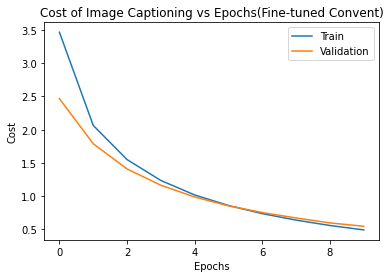

In [ ]:
plt.plot(train_losses2)
plt.plot(validation_losses2)
plt.title("Cost of Image Captioning vs Epochs(Fine-tuned Convent)")
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(labels = ["Train","Validation"])
plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Imagecaptioning_fine_bi.pth'
torch.save(model2.state_dict(), PATH)

In [ ]:
print(train_losses2)

[3.466822963188319, 2.0640582846631483, 1.5501374750281889, 1.2352725649236167, 1.0172223828222295, 0.8582603168168051, 0.7357007244533101, 0.6381994596238924, 0.5574706667258367, 0.4908715059853082]


In [ ]:
print(validation_losses2)

[2.46669278557845, 1.7882320388095585, 1.4088297277454316, 1.1634018911620763, 0.9865647925166633, 0.853784712984806, 0.7521817823798638, 0.6705162068755608, 0.5963319434718354, 0.5457159706105398]


#### Test the Network 

  0%|          | 0/3 [00:00<?, ?it/s]

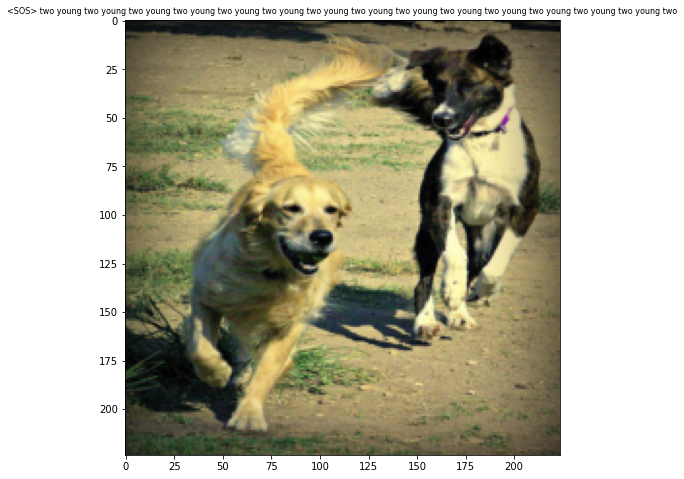

 33%|███▎      | 1/3 [00:00<00:00,  2.33it/s]

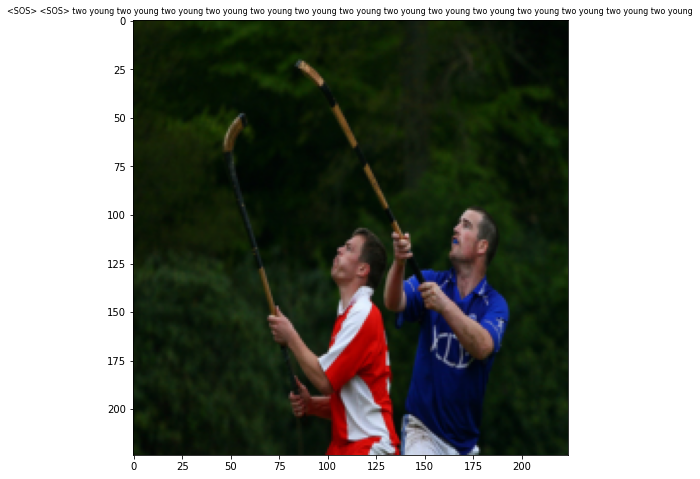

 67%|██████▋   | 2/3 [00:00<00:00,  2.44it/s]

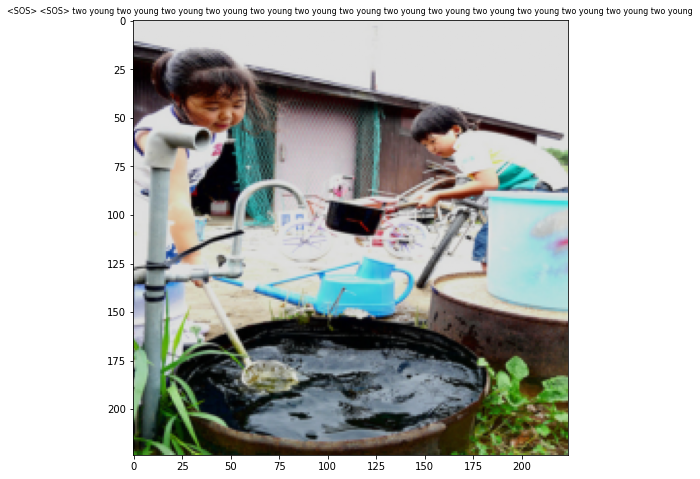

100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


In [ ]:
# Hyperparameters
embedding_size = 300
hidden_size = 256
vocab_size = len(vocab)
num_layers = 1
learning_rate = 1e-4

data_root = "/content/Images"

data_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

kwargs = {'labels_root' : "/content/captions.txt",
          'data_transform' : data_transform,
          'vocab' : vocab,
          }
          
test_set =  Flickr8k_Datset(data_root, partition['test'],**kwargs)

pad_idx = test_set.vocab.str_2_idx["<PAD>"] 

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

test_generator = torch.utils.data.DataLoader(test_set, **params)

PATH = '/content/drive/My Drive/Imagecaptioning_fine_bi.pth'
 
model3 =  ImageCaptioning_Model2(embedding_size, hidden_size, vocab_size, num_layers, feature_extraction_cnn = False).to(device)
model3.load_state_dict(torch.load(PATH))


with torch.set_grad_enabled(False):
    for batch_images, batch_captions in tqdm(test_generator):

        # Transfer to GPU
        batch_images, batch_captions = batch_images.to(device), batch_captions.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model3.caption_prediction(batch_images,batch_captions[:-1])
        test_set.test_network(batch_images.cpu(),batch_outputs)